# Reteción proactiva de clientes bancarios

Proyecto de desarrollo de modelo predictivo de fuga de clientes VIP.

## Diagnóstico del problema

Análisis de los **perfiles de los clientes** que abandonan el paquete premium.

**Curso de acción** para mitigar las bajas.

Data Scientist: Santiago Tedoldi

## Librerias

In [104]:
import os
import pandas as pd
import numpy as np
import seaborn as sns

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer

import pickle

## Datos

In [105]:

base_path = 'C:/Users/santt/Desktop/DataMining_UBA/2-dm_economia_finanzas/competencia_01'

dataset_path = os.path.join(base_path, 'datos')

modelos_path = os.path.join(base_path, 'modelos')

db_path = os.path.join(base_path, 'optimizacion') 

dataset_file = 'competencia_01_brandoni_fe.csv' # con ing. de variables aplicada
# Notebook_comp01_fe.ipynb

ganancia_acierto = 273000
costo_estimulo = 7000

mes_train = 202102
mes_test = 202104

semillas = [437809, 327347, 392879, 455783, 217163]

data = pd.read_csv(os.path.join(dataset_path, dataset_file))

In [106]:
data.clase_ternaria.value_counts()

clase_ternaria
CONTINUA    645053
BAJA+1        4614
BAJA+2        3972
Name: count, dtype: int64

## Código útil

Función para calcular la ganancia.

In [107]:
def ganancia(model, X, y, prop=1, threshold=0.025):

  class_index = np.where(model.classes_ == "BAJA+2")[0][0]
  y_hat = model.predict_proba(X)

  @np.vectorize
  def ganancia_row(predicted, actual, threshold=0.025):
    return  (predicted >= threshold) * (ganancia_acierto if actual == "BAJA+2" else -costo_estimulo)

  return ganancia_row(y_hat[:,class_index], y).sum() / prop

Función para seleccionar mes de prueba y separar X del target o del número de cliente.

In [108]:
def def_xy(data, mes, target='clase_ternaria', to_pred=False):
    
    X = data[data['foto_mes'] == mes]
    y = X[target]
    X = X.drop(columns=[target])

    numero_de_cliente = X['numero_de_cliente']

    if to_pred:
        return X, numero_de_cliente
    else:
        return X, y

## Exploración de datos

En un enfoque general.

In [109]:
# presente
data_pres = data[data['foto_mes'] == mes_test].copy()

# histórico
data_hist = data[data['foto_mes'] < mes_test].copy()

# all data sin últimos meses
data = data[data['foto_mes'] <= mes_test].copy()

In [110]:
data_pres.clase_ternaria.value_counts(normalize=True)

clase_ternaria
CONTINUA    0.986769
BAJA+2      0.007246
BAJA+1      0.005985
Name: proportion, dtype: float64

### Selección de variables a estudiar

Modelo RF para evaluar la importancia de variables predictoras.

In [111]:
X, y = def_xy(data_pres, mes_test)

model_rf = RandomForestClassifier(n_estimators=100, 
                                  max_depth=10, 
                                  random_state=17)

X_imp = X.fillna(0)

model_rf.fit(X_imp, y)

RandomForestClassifier(max_depth=10, random_state=17)

In [112]:
filename = 'modelos/model_rf_ori_eda_miranda.sav'

with open(filename, 'wb') as file:
    pickle.dump(model_rf, file)

print(f'Modelo guardado como {filename}')

Modelo guardado como modelos/model_rf_ori_eda_miranda.sav


In [113]:
filename = 'modelos/model_rf_ori_eda_miranda.sav'
model_rf = pickle.load(open(filename, 'rb'))

In [114]:
feature_importances_rf = pd.DataFrame({'feature': X.columns, 'importance': model_rf.feature_importances_})
feature_importances_rf.sort_values('importance', ascending=False, inplace=True)

feature_importances_rf.fillna(0, inplace=True)
feature_importances_rf.importance = feature_importances_rf.importance/feature_importances_rf.importance.sum()

In [115]:
feature_importances_rf.head(20)

feature  importance
107                   ctrx_quarter    0.034203
156           saldo_total_completo    0.032996
22                  mcuentas_saldo    0.022915
169    prestamos_personales_10tile    0.021439
111                  Master_status    0.021396
18                    mcaja_ahorro    0.020313
170  prestamos_hipotecarios_10tile    0.020284
194             ratio_saldo_margen    0.019517
155            saldo_total_cuentas    0.019481
11                 mpasivos_margen    0.019073
166             caja_ahorro_10tile    0.016281
12                      cproductos    0.015833
16               mcuenta_corriente    0.013745
8             mrentabilidad_annual    0.012837
187     mov_avg_3_cuenta_corriente    0.012834
178         avg_3_cuenta_corriente    0.012479
192          Master_cuenta_cerrada    0.012354
177              lag_1_caja_ahorro    0.012042
190       cuenta_corriente_slope_3    0.011875
183       delta_1_cuenta_corriente    0.011845

### EDA

Simplificación del target o variable a predecir.

In [116]:
data['clase_bin'] = np.where(data['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

data_pres['clase_bin'] = np.where(data_pres['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

data_hist['clase_bin'] = np.where(data_hist['clase_ternaria'] == 'CONTINUA', 'CONTINUA', 'BAJA')

Adaptación de columnas para visualizar.

In [117]:
from feature_adaptation_v00 import adapt_columns

In [118]:
to_float = [
    'ctrx_quarter'
]

to_int = [
    'Master_status',
    'cproductos'
]

to_cut_high_5 = [
    'ctrx_quarter',
    'lag_1_caja_ahorro',
]

to_cut_high_10 = []

to_cut_low_5 = []

to_cut_low_10 = []

to_cut_low_high = [
    'saldo_total_completo',
    'mcuentas_saldo',
    'mpasivos_margen',
    'mrentabilidad_annual',
    'ratio_saldo_margen',
    'mcuenta_corriente',
    'mov_avg_3_cuenta_corriente',
    'avg_3_cuenta_corriente',
    'cuenta_corriente_slope_3',
    'delta_1_cuenta_corriente'
]

to_log = [
    'mcuentas_saldo',
    'mcuenta_corriente'
]

data_eda_gral = adapt_columns(data, to_float, to_int, 
                     to_cut_high_5, to_cut_high_10, to_cut_low_5,
                     to_cut_low_10, to_cut_low_high)

In [119]:
100*len(data_eda_gral)/len(data)

25.55042785084459

Funciones para el análisis.

In [120]:
def summary_statistics(data):
    return data.describe().T.to_markdown()

def summary_statistics_comparative(data1, data2, key1='1', key2='2', stats=None):
    summary1 = data1.describe().T
    summary2 = data2.describe().T

    # Filtrar las columnas de estadísticas si se especifica
    if stats is not None:
        summary1 = summary1[stats]
        summary2 = summary2[stats]

    summary_combined = pd.concat([summary1, summary2], axis=1, keys=[key1, key2])

    # Obtener la lista de estadísticas seleccionadas
    selected_stats = summary1.columns.tolist()

    new_columns = []
    for stat in selected_stats:
        new_columns.extend([(key1, stat), (key2, stat)])

    summary_combined = summary_combined.reindex(columns=new_columns)

    return summary_combined

def is_int(data, feature):
    if pd.api.types.is_numeric_dtype(data[feature]):
        if pd.api.types.is_integer_dtype(data[feature]):
            return True
        else:
            return False

def plot_distributions(data, num_features, target, title_suffix='', sample_frac=0.2, transform='log1p', to_log=[]):
    """Plot distributions of numerical features, determining if they are discrete or continuous,
    and sample the dataset to speed up the process. Apply appropriate transformation to continuous variables."""
    
    data_sampled = data.sample(frac=sample_frac, random_state=42)
    
    for feature in num_features:
        plt.figure(figsize=(10, 4))

        palette = {'CONTINUA': sns.color_palette()[0], 'BAJA': sns.color_palette()[1]}

        # Determine if the feature is discrete or continuous
        if is_int(data_sampled, feature):
            # Obtenemos las clases únicas del target
            target_classes = data_sampled[target].unique()
            
            # Lista para almacenar los DataFrames de frecuencias relativas
            freq_data_list = []
            
            # Calculamos la frecuencia relativa de feature para cada clase del target
            for t_class in target_classes:
                # Filtramos los datos por la clase del target
                data_tclass = data_sampled[data_sampled[target] == t_class]
                
                # Calculamos la frecuencia relativa de cada categoría de feature
                counts = data_tclass[feature].value_counts(normalize=True).reset_index()
                counts.columns = [feature, 'relative_freq']
                counts[target] = t_class  # Añadimos la clase del target
                
                # Añadimos al listado
                freq_data_list.append(counts)
            
            # Concatenamos los DataFrames
            freq_data = pd.concat(freq_data_list, ignore_index=True)
            
            # Graficamos las frecuencias relativas
            sns.barplot(x=feature, y='relative_freq', hue=target, data=freq_data, palette=palette)
            
            # Añadimos etiquetas y título
            plt.title(f'Relative Frequency Plot of {feature} {title_suffix}')
            plt.ylabel('Relative Frequency')

            plt.show()
            
        else:
            if feature in to_log:
                # Handle NaN and negative values before applying log1p
                if transform == 'log1p':
                    positive_values = data_sampled[feature] > 0
                    transformed_feature = np.log1p(data_sampled[feature].where(positive_values))
                    title_t = f'Log1p-Transformed Distribution of {feature} {title_suffix}'
                    x_label = f'Log1p({feature})'
                elif transform == 'sqrt':
                    non_negative_values = data_sampled[feature] - data_sampled[feature].min() + 1
                    transformed_feature = np.sqrt(non_negative_values)
                    title_t = f'Square Root Transformed Distribution of {feature} {title_suffix}'
                    x_label = f'Square Root({feature})'
                
                # Normal plot
                title = f'Distribution of {feature} {title_suffix}'
                df_ = pd.DataFrame({feature: data_sampled[feature], target: data_sampled[target]})
                sns.histplot(data=df_, x=feature, hue=target, kde=True, element='step', stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(title)

                plt.show()

                # Transformed plot
                df_transformed = pd.DataFrame({feature: transformed_feature, target: data_sampled[target]})
                sns.histplot(data=df_transformed, x=feature, hue=target, kde=True, element='step', stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(title_t)
                plt.xlabel(x_label)

                plt.show()

            else:
                title = f'Distribution of {feature} {title_suffix}'
                df_ = pd.DataFrame({feature: data_sampled[feature], target: data_sampled[target]})
                sns.histplot(data=df_, x=feature, hue=target, kde=True, element='step', stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(title)

                plt.show()
        
def plot_correlation_matrix(data, target=None, title_suffix=''):
    data_ = data.copy()
    # Encode the target variable if provided
    if target:
        data_[target] = data_[target].map({"CONTINUA": 0, "BAJA": 1}).astype(float)

        numeric_data = data_.select_dtypes(include=[np.number])
    else:
        numeric_data = data_.select_dtypes(include=[np.number])
    
    # Compute the correlation matrix
    corr_matrix = numeric_data.corr()
    
    # Plot the correlation matrix
    plt.figure(figsize=(12, 8))
    sns.heatmap(corr_matrix, annot=False, fmt=".2f", cmap='coolwarm', square=True)
    plt.title(f'Correlation Matrix {title_suffix}')
    plt.show()

def missing_values_analysis(data_):
    missing_values = data_.isnull().mean() * 100
    return missing_values[missing_values > 0].sort_values(ascending=False)

In [121]:
target = 'clase_bin'  # Your target variable

# Assuming you have your list of the top 10 original relevant variables + target
top_features_with_target = list(feature_importances_rf.feature)[:20] + [target]

# Selecting top columns
data_top = data[top_features_with_target]

print("Resumen Estadístico - Comparativo")
key1= 'BAJA'
key2= 'CONTINUA'
stats=['count', 'mean', '50%', '75%', 'max', 'std']
summary_stats_combined = summary_statistics_comparative(data_top.loc[data_top.clase_bin == key1], 
                                                        data_top.loc[data_top.clase_bin == key2], 
                                                        key1, key2, stats=stats)
print(summary_stats_combined.to_markdown())

Resumen Estadístico - Comparativo
|                               |   ('BAJA', 'count') |   ('CONTINUA', 'count') |   ('BAJA', 'mean') |   ('CONTINUA', 'mean') |   ('BAJA', '50%') |   ('CONTINUA', '50%') |   ('BAJA', '75%') |   ('CONTINUA', '75%') |   ('BAJA', 'max') |   ('CONTINUA', 'max') |   ('BAJA', 'std') |   ('CONTINUA', 'std') |
|:------------------------------|--------------------:|------------------------:|-------------------:|-----------------------:|------------------:|----------------------:|------------------:|----------------------:|------------------:|----------------------:|------------------:|----------------------:|
| ctrx_quarter                  |                7394 |                  645053 |         35.3364    |           119.352      |          17       |             106       |           45      |              158      |    1356           |        2425           |         56.6588   |          87.7314      |
| saldo_total_completo          |                7394 

En términos generales, los clientes premium que dejan el banco:

> ctrx_quarter: 

Muestran un merma significativa en su actividad/movimientos durante los últimos meses, siendo 3 veces inferior respecto a los clientes que permancen en el banco.

> saldo_total_completo y mcuentas_saldo: 

Los saldos en las cuentas también resultan significativamente más bajos (10 veces menos en promedio).

> Master_status: 

Otro dato relevante es el estado de sus tarjetas. En el caso de las cuentas master, hay una porción (< 5 %) de los cliente en fuga que avanzan en el cierra o la cancelación de las tarjetas previo a dejar el paquete premium.

> prestamos_personales_10tile y prestamos_hipotecarios_10tile: 

Por otro lado, acceden a una cantidad reducida de prestamos, tanto personales como hipotecarios, en comparación a quienes continuan (2 vs 6 en la midad de los casos)

> mpasivos_margen: 

El margen pasivo que el banca está obteniendo en los clientes próximos a irse es muy inferior, en términos medios 18 veces menos, al de aquellos que continúan.

> mrentabilidad_annual: 

Sin embargo, en términos de rentabilidad anual, el banco ha sacado provecho de los clientes próximos a irse. En términos medios, un 66 % de la renta comparado con los clientes ya fidelizados.

> mcaja_ahorro y caja_ahorro_10tile: 

Si observamos la estadística de las cajas de ahorro, también vemos cajas con montos bajos de aquellos próximos a abandonar la institución. En término medio, los clientes que se van están en el decil 1/10 (el más bajo), mientras que los que continúan están en el decil 6/10.

> mcuenta_corriente y avg_3_cuenta_corriente (sin visualización): 

Finalmente, si observamos las cuentas corrientes fuera del paquete, también veremos saldos promedios negativos en clientes pronto a irse.

Distribution of Numerical Features - All Data


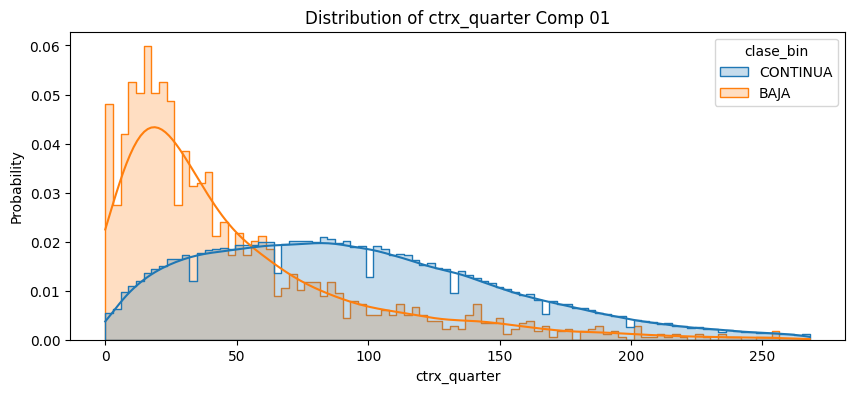

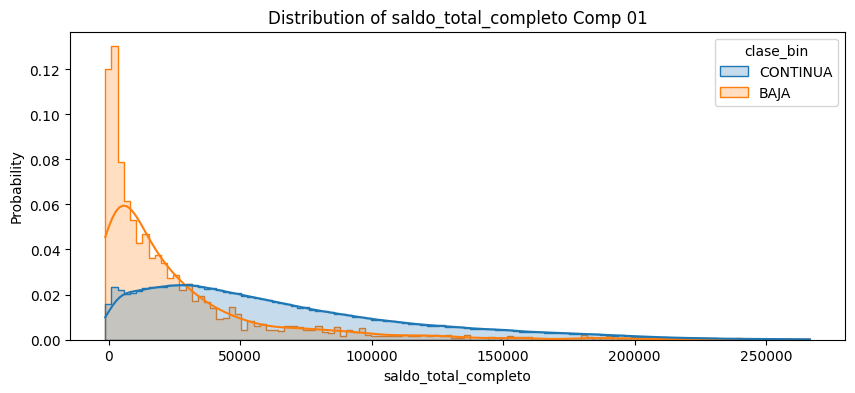

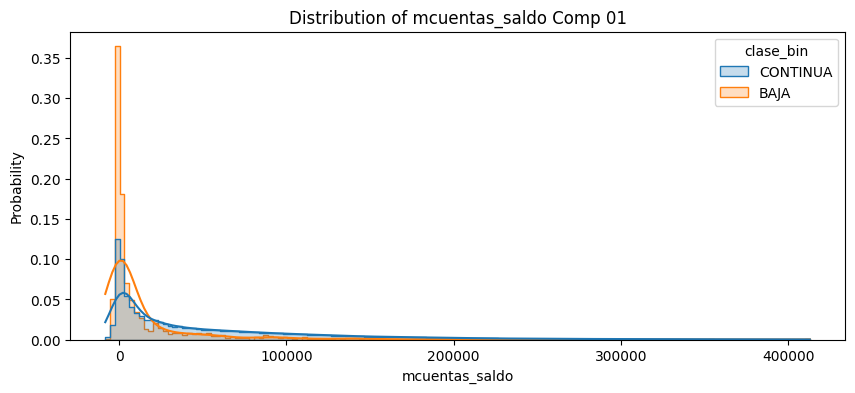

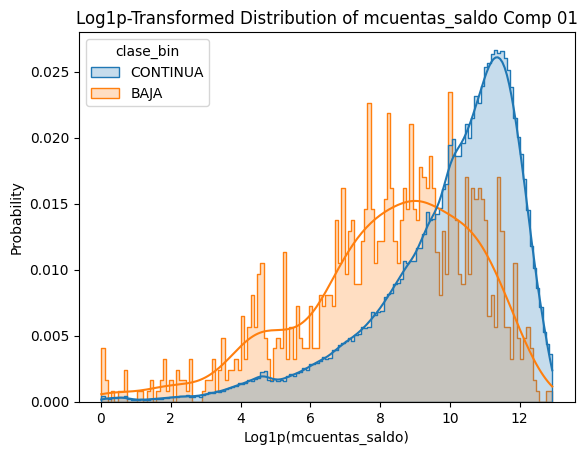

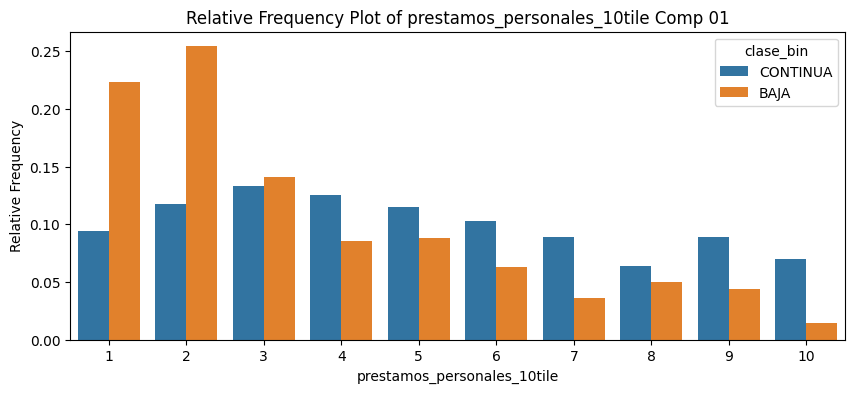

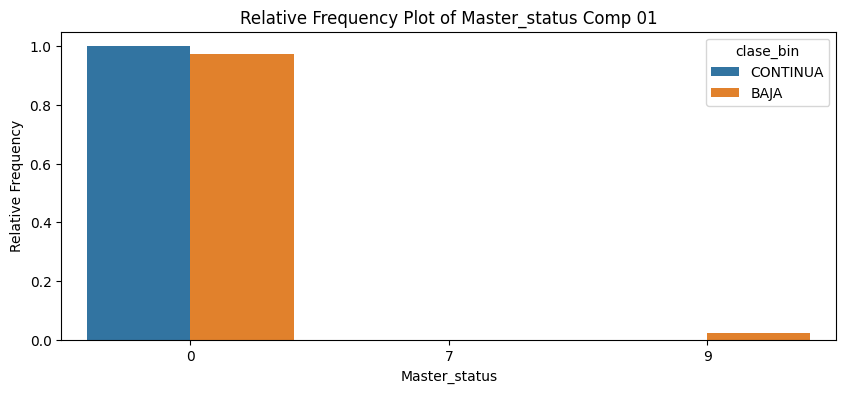

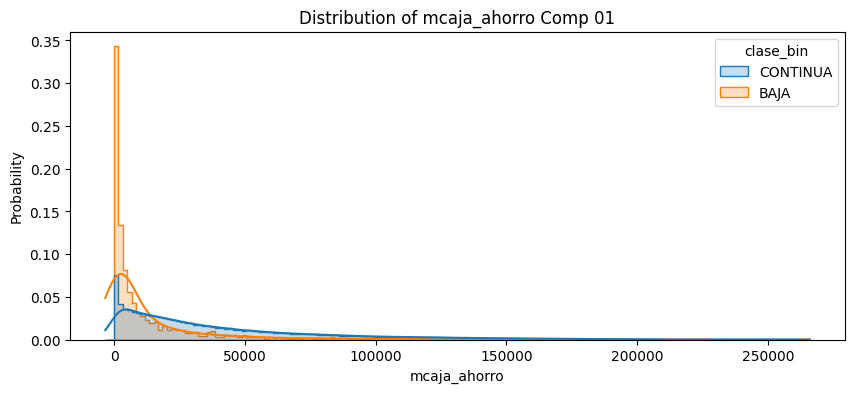

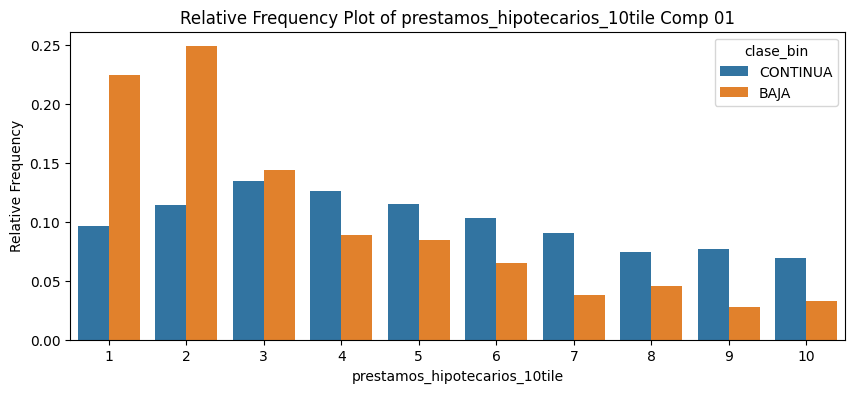

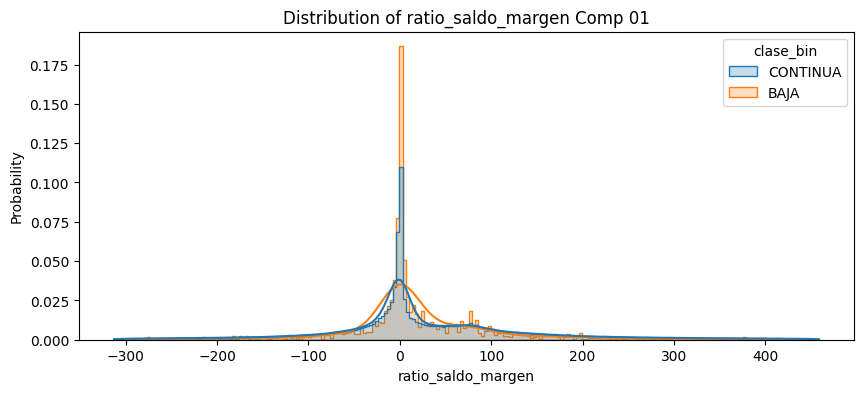

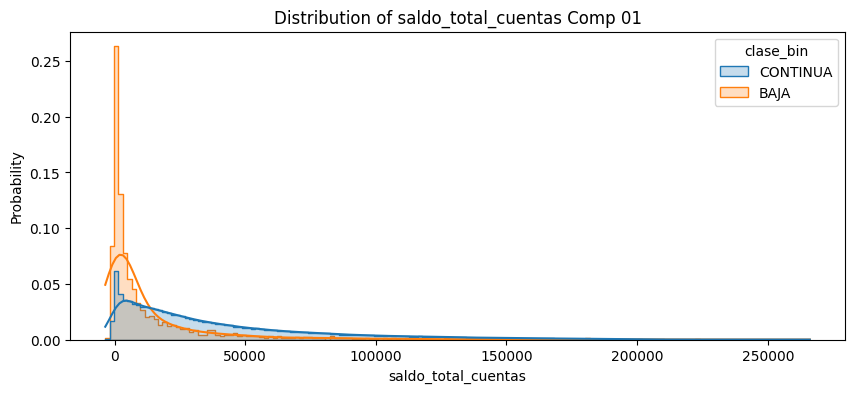

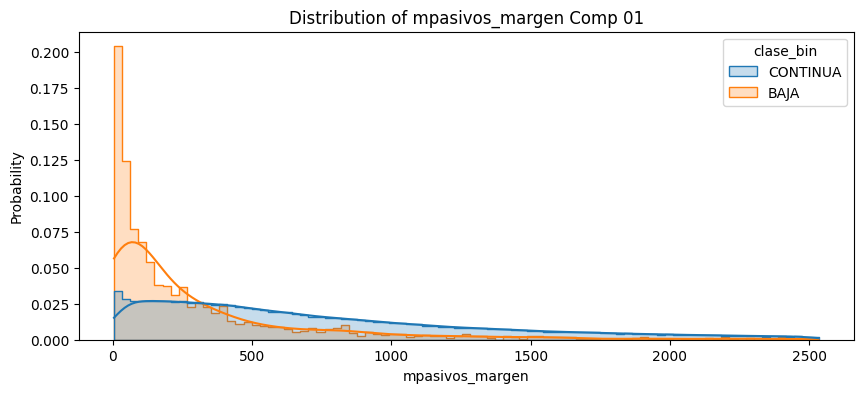

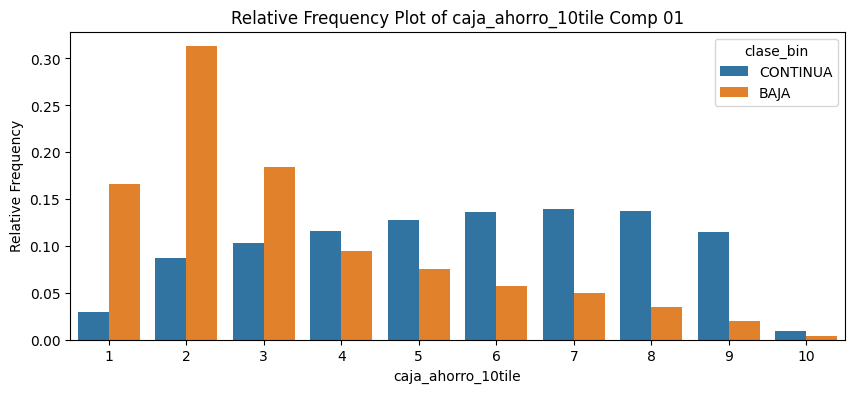

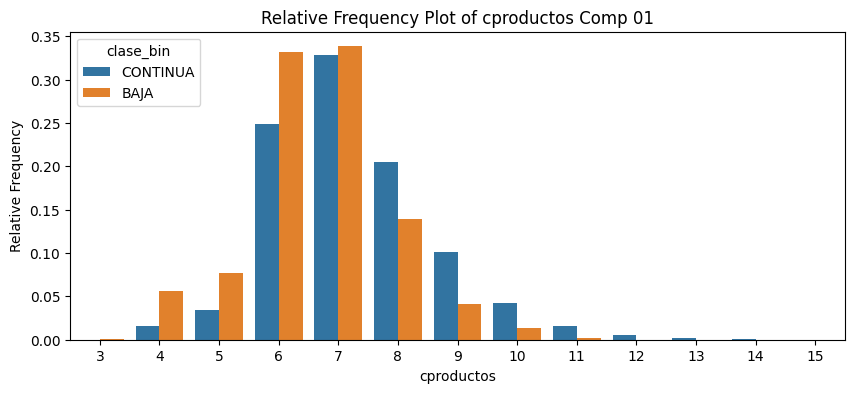

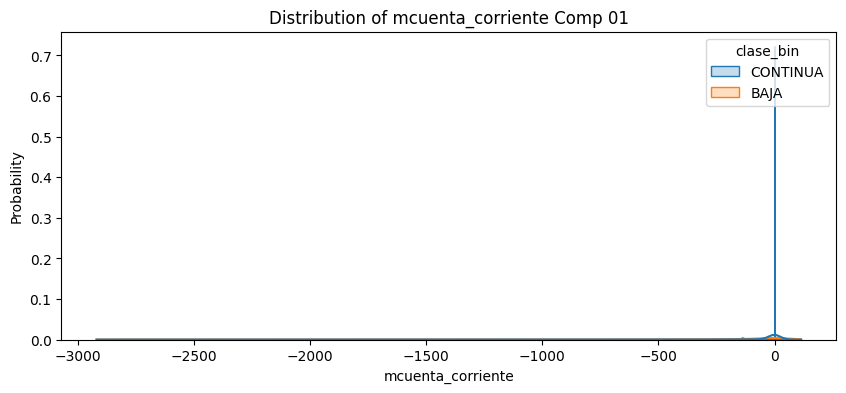

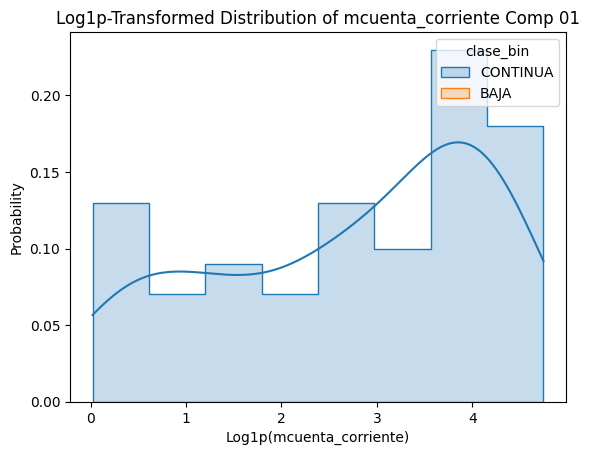

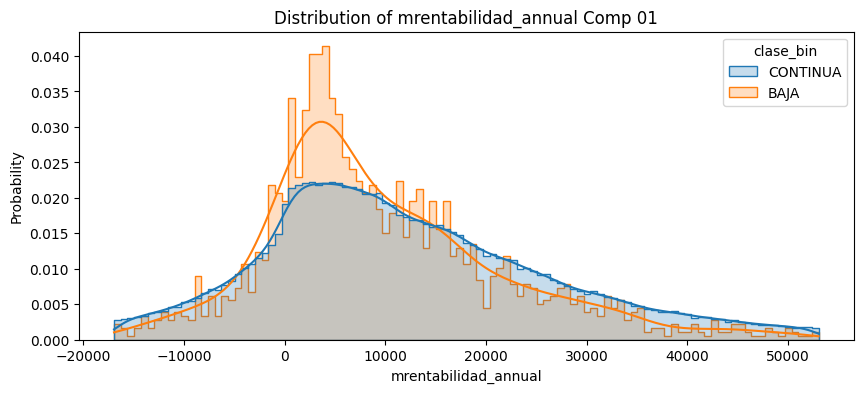

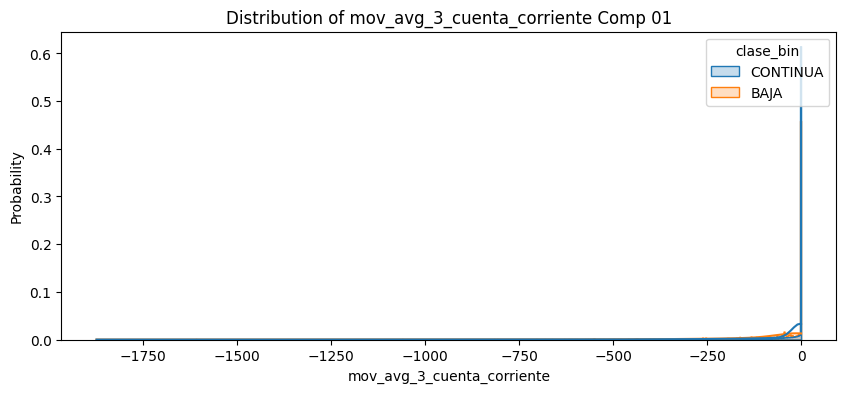

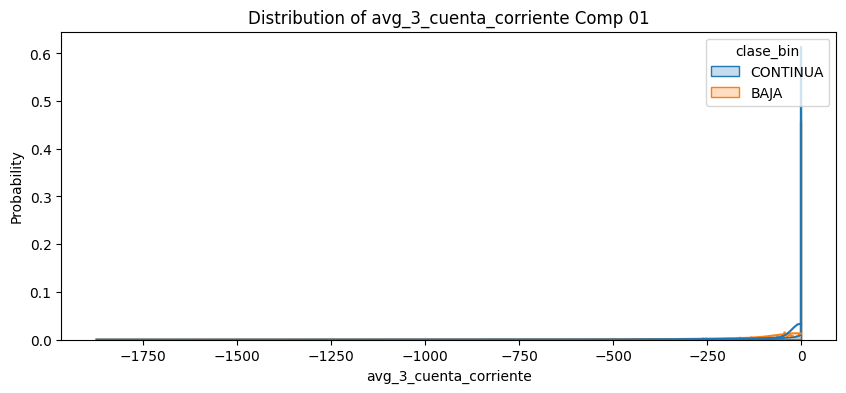

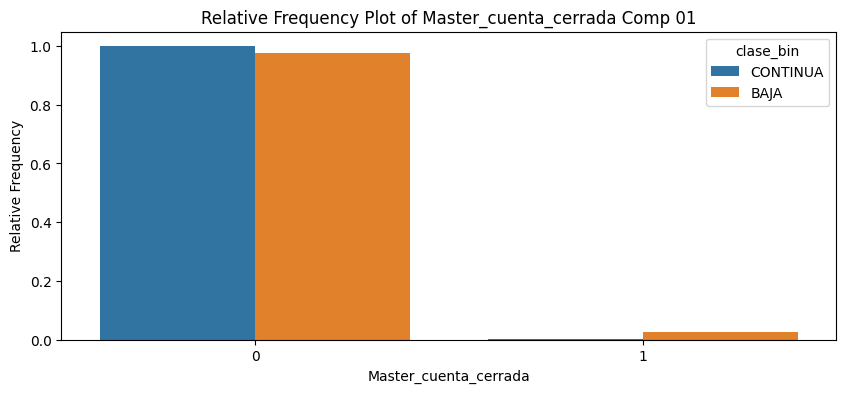

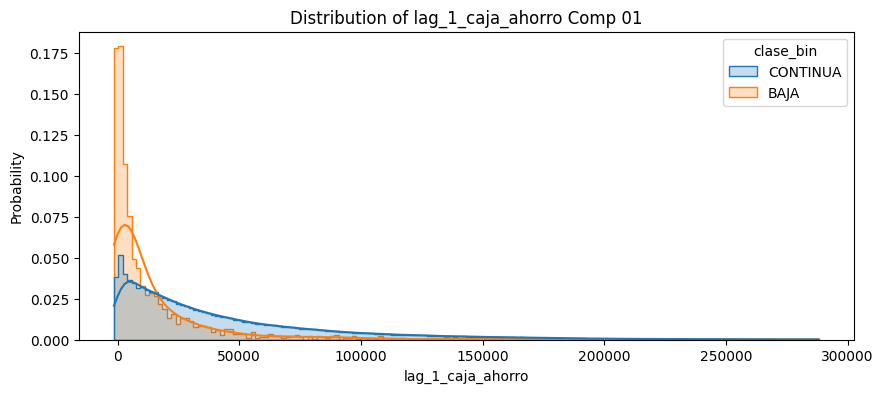

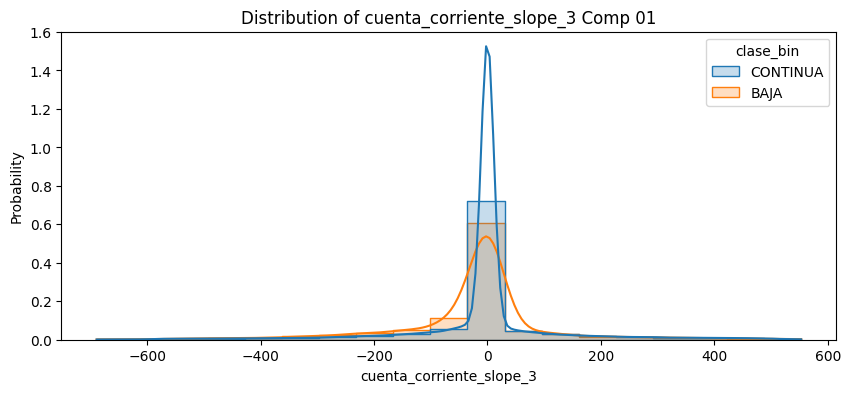

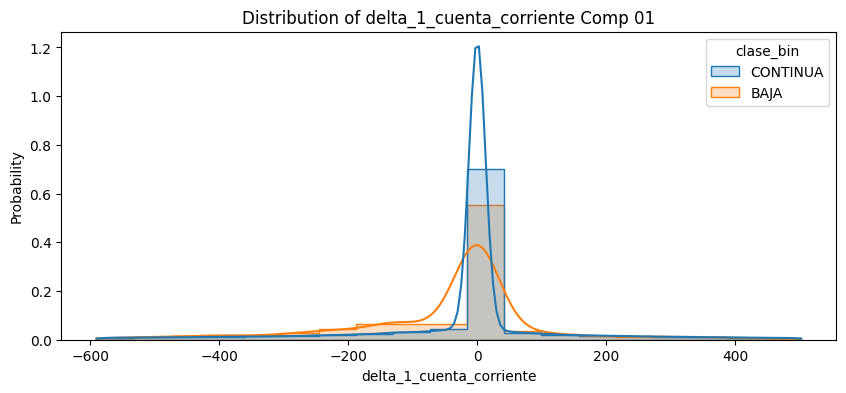

Correlation Matrix - 202104 Data


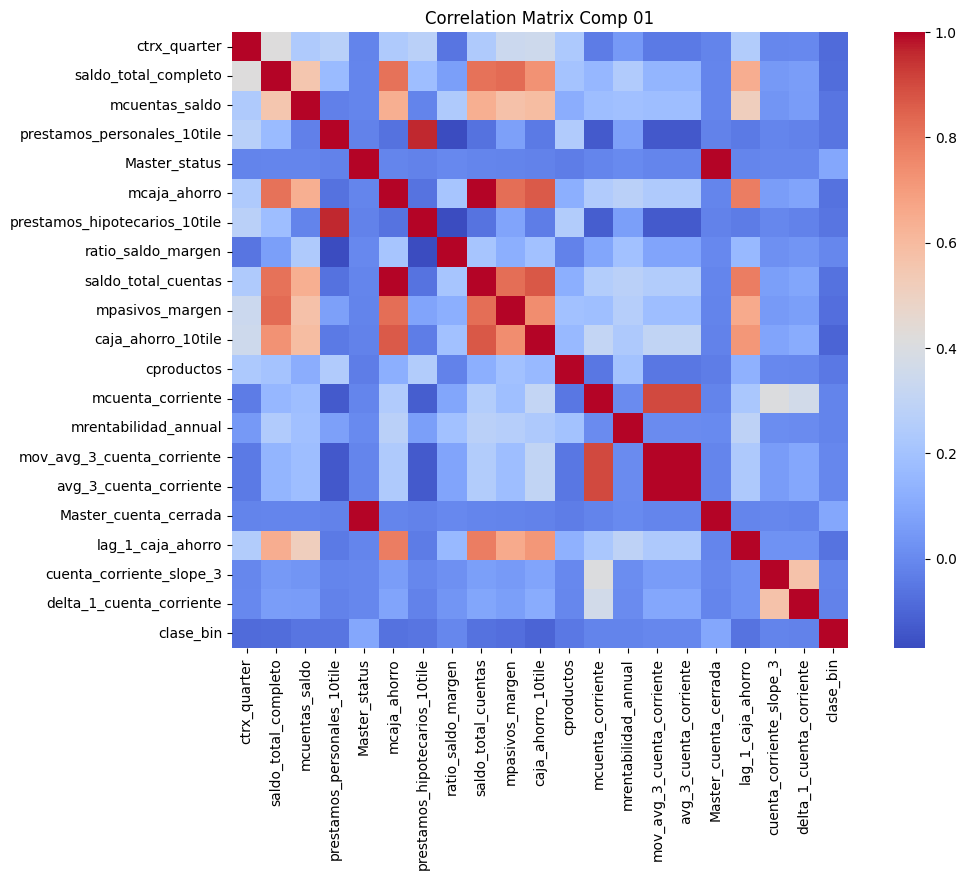

Missing Values - 202104 Data
Series([], dtype: float64)


In [122]:
# Cambio el data_top luego de recortar los casos para una mejor visualización
data_top = data_eda_gral[top_features_with_target]

# Distribution of numerical features
numeric_features = data_top.select_dtypes(include=[np.number]).columns.tolist()

print("Distribution of Numerical Features - All Data")
plot_distributions(data_top, numeric_features, 
                   target=target, title_suffix='Comp 01', 
                   transform='log1p', sample_frac=1, to_log=to_log)

# Correlation Matrix
print("Correlation Matrix - 202104 Data")
plot_correlation_matrix(data_top, target=target, title_suffix='Comp 01')

# Missing Values Analysis
print("Missing Values - 202104 Data")
print(missing_values_analysis(data_top))

## Segmentación de clientes

Usando el mes de abril, ya que se cuenta con variables históricas creadas en el proceso de ingeniería de variables "Notebook_comp01_fe.ipynb".


In [123]:
df_train = data[data['foto_mes']==202104] #abril

# Training set
X_train = df_train
y_train = X_train["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)
X_train = X_train.drop(["clase_ternaria","clase_bin"], axis=1)

del(df_train)

Muestreo sobre CONTINUA y BAJAS para reducir el cómputo y mejorar la segmentación.

In [124]:
np.random.seed(17)
continua_sample = y_train[y_train == 0].sample(int(0.05*len(y_train))).index
bajas_1_2 = y_train[y_train == 1].index
rf_index = continua_sample.union(bajas_1_2)

X_train_rf = X_train.loc[rf_index]
y_train_rf = y_train.loc[rf_index]


RandomForestClassifier para segmentar clientes.

In [125]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
X_train_rf_imp = imp_mean.fit_transform(X_train_rf)

model = RandomForestClassifier(n_estimators=100,
        max_depth=28,
        max_features=0.3,
        min_samples_leaf=138,
        min_samples_split=5,
        max_samples=0.7,
        random_state=semillas[0],
        n_jobs=-1,
        oob_score=True)

model.fit(X_train_rf_imp, y_train_rf)

RandomForestClassifier(max_depth=28, max_features=0.3, max_samples=0.7,
                       min_samples_leaf=138, min_samples_split=5, n_jobs=-1,
                       oob_score=True, random_state=437809)

Función que calcule la **matriz de distancias** a partir del bosque entrenado.

In [126]:
def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

md = distanceMatrix(model, X_train_rf_imp)

In [127]:
md

array([[0.  , 0.89, 0.94, ..., 1.  , 1.  , 0.99],
       [0.89, 0.  , 0.88, ..., 1.  , 1.  , 1.  ],
       [0.94, 0.88, 0.  , ..., 1.  , 1.  , 0.97],
       ...,
       [1.  , 1.  , 1.  , ..., 0.  , 0.68, 1.  ],
       [1.  , 1.  , 1.  , ..., 0.68, 0.  , 1.  ],
       [0.99, 1.  , 0.97, ..., 1.  , 1.  , 0.  ]])

Embedding usando UMAP y la matriz de distancia calculada.

c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\umap\umap_.py:1858: UserWarning: using precomputed metric; inverse_transform will be unavailable
  warn("using precomputed metric; inverse_transform will be unavailable")
c:\Users\santt\.conda\envs\dm_eyf\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


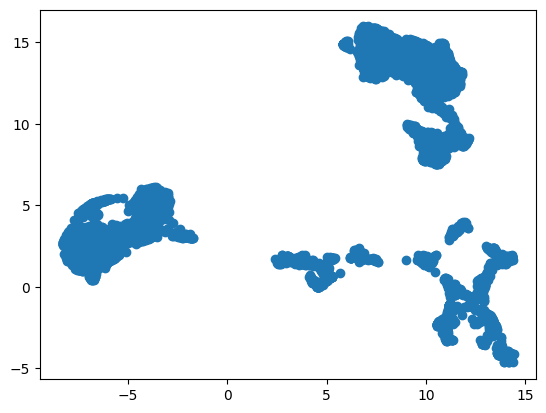

In [128]:
embedding_rf = UMAP(
  n_components=2,
  n_neighbors=50,
  metric="precomputed",
  random_state=17,
).fit_transform(md)

plt.scatter(embedding_rf[:,0], embedding_rf[:,1])

Agreguemos la dimensión de la probabilidad de salida, para ver donde cree el modelo que se encuentran los **bajas**.

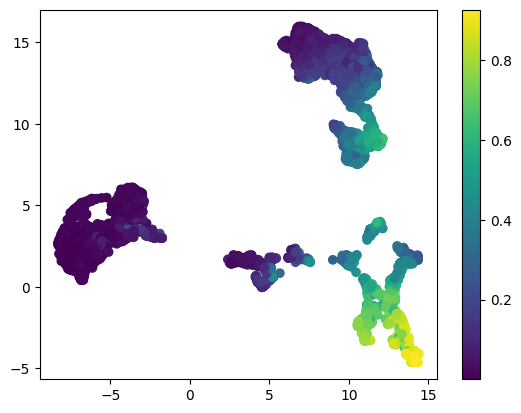

In [129]:
class_index = np.where(model.classes_ == 1)[0]
prob_baja = model.predict_proba(X_train_rf_imp)[:,class_index]

plt.scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja)
plt.colorbar()
plt.show()

### Clustering

DBSCAN para agrupar los clientes bajo estudio.

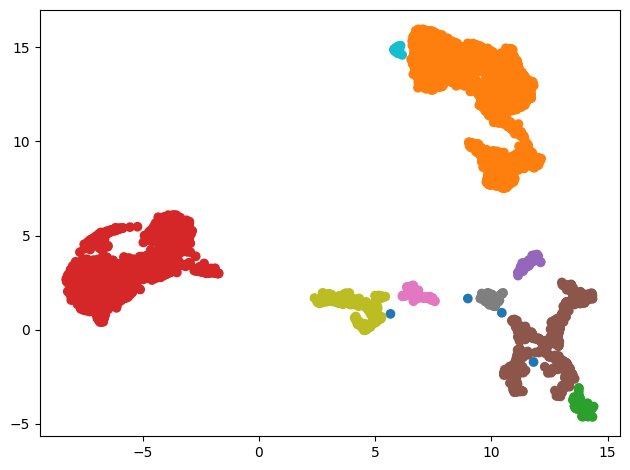

In [130]:
hdb = DBSCAN(eps=0.4) 
y = hdb.fit(embedding_rf)

plt.scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y.labels_, cmap='tab10')
plt.tight_layout()
plt.show()

#### Análisis de los clusters

Individuos por cluster.

In [131]:
pd.Series(y.labels_).value_counts()

 0    4028
 2    3674
 4    1233
 7     637
 1     265
 3     179
 6     158
 5     142
 8      55
-1       4
Name: count, dtype: int64

Variables relevantes para cada cluster.

In [132]:
df_embedding = pd.DataFrame(embedding_rf, columns=['embedding_1', 'embedding_2'])
df_embedding['cluster'] = y.labels_

clusters = df_embedding['cluster'].unique()

important_features_by_cluster = {}

for cluster in clusters:
  y_binary = (df_embedding['cluster'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  model.fit(X_train_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = X_train_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster[cluster] = [feature_names[i] for i in indices]

Visualización del TOP5 de las variables relevantes para cada cluster.

In [133]:
for cluster, features in important_features_by_cluster.items():
  print(f"Cluster {cluster} vs. Resto:")
  for feature in features[:5]:
    print(f"  - {feature}")


Cluster 0 vs. Resto:
  - cpayroll_trx
  - max_3_mpayroll
  - payroll_10tile
  - mov_avg_3_mpayroll
  - min_3_mpayroll
Cluster 1 vs. Resto:
  - cproductos
  - saldo_total_completo
  - lag_1_cuenta_corriente
  - saldo_total_cuentas
  - mov_avg_3_cuenta_corriente
Cluster 2 vs. Resto:
  - cpayroll_trx
  - max_3_mpayroll
  - payroll_10tile
  - mpayroll
  - mov_avg_3_mpayroll
Cluster 3 vs. Resto:
  - ctrx_quarter
  - cprestamos_personales
  - deuda_total_prestamos
  - prestamos_personales_10tile
  - min_3_prestamos_personales
Cluster 4 vs. Resto:
  - master_consumo_10tile
  - visa_consumo_10tile
  - ctarjeta_visa_transacciones
  - visa_tarjetas_10tile
  - prestamos_personales_10tile
Cluster 5 vs. Resto:
  - ctrx_quarter
  - mpayroll
  - cpayroll_trx
  - max_3_mpayroll
  - total_comisiones_cliente
Cluster 6 vs. Resto:
  - ctrx_quarter
  - saldo_total_completo
  - mcaja_ahorro
  - saldo_total_cuentas
  - caja_ahorro_10tile
Cluster 7 vs. Resto:
  - payroll_10tile
  - mpayroll
  - visa_consumo_1

Agrupamos las variables relevantas TOP5 para cada grupo.

In [134]:
important_vars_set = set()

# Iterar sobre cada cluster y tomar las 10 primeras variables
for cluster, variables in important_features_by_cluster.items():
    important_vars_set.update(variables[:5])  # Agregar las 10 primeras variables al set

# Mostrar el conjunto resultante
print(important_vars_set)

{'total_comisiones_cliente', 'cseguro_auto', 'cproductos', 'saldo_total_cuentas', 'ratio_saldo_margen', 'mov_avg_3_mpayroll', 'mov_avg_3_cuenta_corriente', 'mpayroll', 'mrentabilidad_annual', 'deuda_total_prestamos', 'ctarjeta_visa_transacciones', 'avg_3_mpayroll', 'max_3_mpayroll', 'delta_1_cuenta_corriente', 'mcaja_ahorro', 'mactivos_margen', 'visa_tarjetas_10tile', 'cprestamos_personales', 'caja_ahorro_10tile', 'min_3_prestamos_personales', 'mpasivos_margen', 'master_consumo_10tile', 'lag_1_cuenta_corriente', 'mcaja_ahorro_adicional', 'min_3_mpayroll', 'cpayroll_trx', 'visa_consumo_10tile', 'saldo_total_completo', 'payroll_10tile', 'ctrx_quarter', 'prestamos_personales_10tile'}


In [135]:
len(important_vars_set)

31

#### Dataframe completo con clusters

In [136]:
df_segmented = pd.concat([X_train_rf, y_train_rf], axis=1)
df_segmented['proba_rf'] = prob_baja

df_segmented.reset_index(inplace=True)
df_segmented

index  numero_de_cliente  foto_mes  active_quarter  cliente_vip  \
0          27          249584210    202104               1            0   
1         189          251114514    202104               1            0   
2         253          251808341    202104               1            0   
3         324          252477592    202104               1            0   
4         360          253208252    202104               1            0   
...       ...                ...       ...             ...          ...   
10370  981748         1559791115    202104               1            0   
10371  981771         1560582663    202104               1            0   
10372  981774         1560674337    202104               1            0   
10373  981859         1583832396    202104               1            0   
10374  981863         1586773541    202104               1            0   

       internet  cliente_edad  cliente_antiguedad  mrentabilidad  \
0             0            54                 196         695.96   
1             0            54                 291        5070.43   
2             0            59                 323        4380.62   
3             0            75                 323        2610.59   
4             0            51                 169        5667.78   
...         ...           ...                 ...            ...   
10370         0            29                   6        1645.12   
10371         0            31                   4        -991.36   
10372         0            28                   6         718.83   
10373         0            31                   3         789.28   
10374         0            47                   3        4748.99   

       mrentabilidad_annual  ...  visa_consumo_slope_3  Master_cuenta_cerrada  \
0                  15598.37  ...             -7598.380                      0   
1                  46194.44  ...              2461.307                      0   
2                  22964.65  ...             -8114.388                      0   
3                   9814.91  ...              2092.125                      0   
4                  32548.06  ...               915.892                      0   
...                     ...  ...                   ...                    ...   
10370              15474.86  ...              8297.890                      0   
10371              -1472.68  ...              3700.279                      0   
10372              -7432.59  ...                   NaN                      0   
10373               2014.13  ...             32313.390                      0   
10374              21955.93  ...                 0.000                      0   

       Visa_cuenta_cerrada  ratio_saldo_margen  total_comisiones_cliente  \
0                        0          796.544656                   3091.06   
1                        0           81.913110                   4854.01   
2                        0          -13.249547                   6710.78   
3                        0          -20.335430                   4272.72   
4                        0           89.119272                    433.18   
...                    ...                 ...                       ...   
10370                    0           36.005201                    587.43   
10371                    0           -0.249195                    425.72   
10372                    0          133.954356                    260.37   
10373                    0           -0.241386                    361.02   
10374                    0            3.238124                    505.92   

       transacciones_totales_tarjetas  delta_debito_vs_credito  \
0                                  14                      -12   
1                                   2                       -2   
2                                   9                       -9   
3                                   9                       -9   
4                                   5                        8   
...     

Agrego datos de los embeddings.

In [137]:
df_segmented = pd.concat([df_segmented,df_embedding], axis=1)

df_segmented['clase_bin'] = df_segmented['clase_ternaria']

df_segmented['clase'] = df_segmented['clase_bin'].replace({0: 'CONTINUA', 1: 'BAJA'})

df_segmented

index  numero_de_cliente  foto_mes  active_quarter  cliente_vip  \
0          27          249584210    202104               1            0   
1         189          251114514    202104               1            0   
2         253          251808341    202104               1            0   
3         324          252477592    202104               1            0   
4         360          253208252    202104               1            0   
...       ...                ...       ...             ...          ...   
10370  981748         1559791115    202104               1            0   
10371  981771         1560582663    202104               1            0   
10372  981774         1560674337    202104               1            0   
10373  981859         1583832396    202104               1            0   
10374  981863         1586773541    202104               1            0   

       internet  cliente_edad  cliente_antiguedad  mrentabilidad  \
0             0            54                 196         695.96   
1             0            54                 291        5070.43   
2             0            59                 323        4380.62   
3             0            75                 323        2610.59   
4             0            51                 169        5667.78   
...         ...           ...                 ...            ...   
10370         0            29                   6        1645.12   
10371         0            31                   4        -991.36   
10372         0            28                   6         718.83   
10373         0            31                   3         789.28   
10374         0            47                   3        4748.99   

       mrentabilidad_annual  ...  transacciones_totales_tarjetas  \
0                  15598.37  ...                              14   
1                  46194.44  ...                               2   
2                  22964.65  ...                               9   
3                   9814.91  ...                               9   
4                  32548.06  ...                               5   
...                     ...  ...                             ...   
10370              15474.86  ...                              12   
10371              -1472.68  ...                               6   
10372              -7432.59  ...                              11   
10373               2014.13  ...                              49   
10374              21955.93  ...                               0   

       delta_debito_vs_credito  indicador_banca_digital  clase_ternaria  \
0                          -12                        1               0   
1                           -2                        1               0   
2                           -9                        1               1   
3                           -9                        1               0   
4                            8                        1               0   
...                        ...                      ...             ...   
10370                        4                        1               0   
10371                       -5                        0               0   
10372                       22                        1               0   
10373                      -47                        1               0   
10374                        8                        1               0   

       proba_rf  embedding_1  embedding_2  cluster  clase_bin     clase  
0      0.070717     7.043327    14.854462        0          0  CONTINUA  
1      0.216775     9.179012     9.791732        0          0  CONTINUA  
2      0.128423     8.868026    14.161939        0          1      BAJA  
3      0.327006    10.616696    11.864646        0          0  CONTINUA  
4      0.070114     6.841160    13.994014        0          0  CONTINUA  
...         ...          ...          ...      ...        ...       ...  
10370  0.015992    -3.583476     6.092994        2    

In [138]:
df_segmented['clase'].value_counts()

clase
CONTINUA    8204
BAJA        2171
Name: count, dtype: int64

In [139]:
df_segmented['cluster'].value_counts()

cluster
 0    4028
 2    3674
 4    1233
 7     637
 1     265
 3     179
 6     158
 5     142
 8      55
-1       4
Name: count, dtype: int64

Función para relevar estatísticas de los clusters.

In [140]:
# Definir función para agregar estadísticas de clase
def class_stats(group):
    counts = group['clase'].value_counts()
    proportions = group['clase'].value_counts(normalize=True)
    return pd.Series({
        'BAJA_c': counts.get('BAJA', 0),
        'CONTINUA_c': counts.get('CONTINUA', 0),
        'BAJA_p': proportions.get('BAJA', 0),
        'CONTINUA_p': proportions.get('CONTINUA', 0),
        'proba_rf_mean': group['proba_rf'].mean(),
        'proba_rf_std': group['proba_rf'].std(),
        'proba_rf_min': group['proba_rf'].min(),
        'proba_rf_max': group['proba_rf'].max()
    })

# Aplicar agrupación y agregaciones para los clusters
cluster_stats = df_segmented.groupby('cluster').apply(class_stats).reset_index()

cluster_stats

cluster  BAJA_c  CONTINUA_c    BAJA_p  CONTINUA_p  proba_rf_mean  \
0       -1     1.0         3.0  0.250000    0.750000       0.448200   
1        0   879.0      3149.0  0.218222    0.781778       0.213912   
2        1   259.0         6.0  0.977358    0.022642       0.898494   
3        2    34.0      3640.0  0.009254    0.990746       0.016795   
4        3    65.0       114.0  0.363128    0.636872       0.486836   
5        4   812.0       421.0  0.658556    0.341444       0.621526   
6        5     6.0       136.0  0.042254    0.957746       0.179317   
7        6    73.0        85.0  0.462025    0.537975       0.394172   
8        7    42.0       595.0  0.065934    0.934066       0.094601   
9        8     0.0        55.0  0.000000    1.000000       0.057673   

   proba_rf_std  proba_rf_min  proba_rf_max  
0      0.181039      0.289607      0.687048  
1      0.157258      0.018110      0.746258  
2      0.038451      0.635791      0.927202  
3      0.023198      0.000235      0.240507  
4      0.061735      0.317775      0.630504  
5      0.190711      0.178864      0.891546  
6      0.086418      0.052269      0.459172  
7      0.061023      0.254973      0.584576  
8      0.083751      0.012562      0.500336  
9      0.025310      0.020095      0.149161

Luego de un ejercicio de segmentación de clientes VIP, encontramos:

Cluster 1: 98 % de bajas, con 259 casos -> 'Bajas'

Cluster 4: 66 % de bajas, con 812 casos -> 'Bajas probables'

Cluster 0: 22 % de bajas, con 879 casos -> 'Casos complejos'

Cluster 3 y 6: 36 % y 46 % de bajas, con 65 y 73 casos resp. -> 'Bajas dudosas'

Cluster 2: 1 % de bajas, con 34 casos -> 'Continua'

Cluter 5, 7 y 8: 4 %, 7 % y 0 % de bajas, con 6, 42 y 0 casos -> 'Continua*'

Esta agrupación manual va a permitir simplificar la explicación de los perfiles de clientes que dejan el banco, vs. aquellos que continuan con el paquete premium.

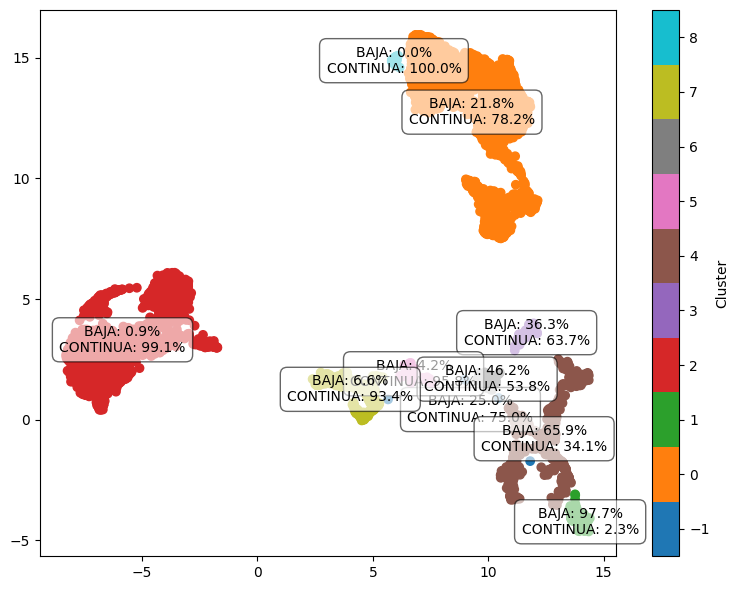

In [141]:
plt.figure(figsize=(8, 6))

scatter = plt.scatter(df_segmented.embedding_1, df_segmented.embedding_2, c=df_segmented.cluster.astype(int), cmap='tab10')

for idx, row in cluster_stats.iterrows():
    # Tomar el centro aproximado de cada cluster para colocar el texto
    cluster_center = df_segmented[df_segmented['cluster'] == row['cluster']][['embedding_1', 'embedding_2']].mean()
    
    # Formato de las proporciones
    text_label = f"BAJA: {100*row['BAJA_p']:.1f}%\nCONTINUA: {100*row['CONTINUA_p']:.1f}%"
    
    # Añadir texto al gráfico
    plt.text(cluster_center['embedding_1'], cluster_center['embedding_2'], 
             text_label, fontsize=10, ha='center', va='center', 
             bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5'))

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico
cbar = plt.colorbar(scatter, boundaries=np.arange(df_segmented['cluster'].min() - 0.5, 
                                                  df_segmented['cluster'].max() + 1.5, 1))
cbar.set_ticks(np.arange(df_segmented['cluster'].min(), df_segmented['cluster'].max() + 1))
cbar.set_label('Cluster')

plt.show()

In [142]:
cluster_mapping = {
    1: 'BAJAS',
    4: 'BAJAS probables',
    0: 'COMPLEJOS',
    3: 'BAJAS dudosas',
    6: 'BAJAS dudosas',
    2: 'CONTINUA',
    5: 'CONTINUA*',
    7: 'CONTINUA*',
    8: 'CONTINUA*',
    -1: 'OUTLIERS',
}

df_segmented['cluster_red'] = df_segmented['cluster'].map(cluster_mapping)

In [143]:
# Definir función para agregar estadísticas de clase
def class_stats(group):
    counts = group['clase'].value_counts()
    proportions = group['clase'].value_counts(normalize=True)
    return pd.Series({
        'BAJA_c': int(counts.get('BAJA', 0)),
        'CONTINUA_c': int(counts.get('CONTINUA', 0)),
        'CASOS': int(counts.get('BAJA', 0) + counts.get('CONTINUA', 0)),
        'BAJA_p': proportions.get('BAJA', 0),
        'CONTINUA_p': proportions.get('CONTINUA', 0),
        'proba_rf_mean': group['proba_rf'].mean(),
        'proba_rf_std': group['proba_rf'].std(),
        'proba_rf_min': group['proba_rf'].min(),
        'proba_rf_max': group['proba_rf'].max()
    })

# Aplicar agrupación y agregaciones para los clusters
cluster_stats = df_segmented.groupby('cluster_red').apply(class_stats).reset_index()

cluster_stats

cluster_red  BAJA_c  CONTINUA_c   CASOS    BAJA_p  CONTINUA_p  \
0            BAJAS   259.0         6.0   265.0  0.977358    0.022642   
1    BAJAS dudosas   138.0       199.0   337.0  0.409496    0.590504   
2  BAJAS probables   812.0       421.0  1233.0  0.658556    0.341444   
3        COMPLEJOS   879.0      3149.0  4028.0  0.218222    0.781778   
4         CONTINUA    34.0      3640.0  3674.0  0.009254    0.990746   
5        CONTINUA*    48.0       786.0   834.0  0.057554    0.942446   
6         OUTLIERS     1.0         3.0     4.0  0.250000    0.750000   

   proba_rf_mean  proba_rf_std  proba_rf_min  proba_rf_max  
0       0.898494      0.038451      0.635791      0.927202  
1       0.443392      0.076836      0.254973      0.630504  
2       0.621526      0.190711      0.178864      0.891546  
3       0.213912      0.157258      0.018110      0.746258  
4       0.016795      0.023198      0.000235      0.240507  
5       0.106589      0.088491      0.012562      0.500336  
6       0.448200      0.181039      0.289607      0.687048

En este ejercicio de segmentación contamos con:

2171 casos de BAJA: correspondientes a abril (202104)

8204 casos de CONTINUA: seleccionados al azar del mismo mes

In [144]:
sum(cluster_stats.BAJA_c)

2171.0

In [145]:
sum(cluster_stats.CONTINUA_c)

8204.0

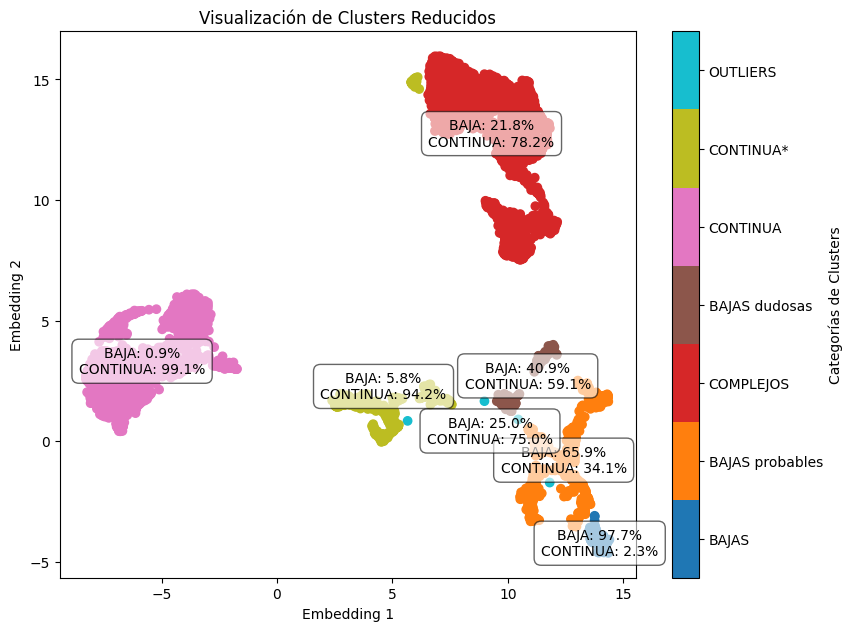

In [146]:
plt.figure(figsize=(8, 6))

# Nuevo mapeo de etiquetas de cluster a enteros
cluster_label_mapping = {
    'BAJAS': 0,
    'BAJAS probables': 1,
    'COMPLEJOS': 2,
    'BAJAS dudosas': 3,
    'CONTINUA': 4,
    'CONTINUA*': 5,
    'OUTLIERS': 6
}

# Mapear 'cluster_red' a valores enteros para la visualización
df_segmented['cluster_red_int'] = df_segmented['cluster_red'].map(cluster_label_mapping)

# Crear el scatter plot
scatter = plt.scatter(
    df_segmented['embedding_1'],
    df_segmented['embedding_2'],
    c=df_segmented['cluster_red_int'],
    cmap='tab10'
)

# Agregar leyenda
handles = [
    plt.Line2D([], [], marker="o", color=scatter.cmap(scatter.norm(i)), linestyle="", markersize=10)
    for i in range(len(cluster_label_mapping))
]
labels = list(cluster_label_mapping.keys())
# plt.legend(handles, labels, title="Categorías", bbox_to_anchor=(1.05, 1), loc='upper left')

# Añadir etiquetas de texto con porcentajes al centro de cada cluster reducido
for cluster_name in df_segmented['cluster_red'].unique():
    # Filtrar datos del cluster actual
    cluster_data = df_segmented[df_segmented['cluster_red'] == cluster_name]
    
    # Calcular el centro del cluster
    cluster_center = cluster_data[['embedding_1', 'embedding_2']].mean()
    
    # Obtener estadísticas del cluster (asegúrate de que 'cluster_stats' tenga esta información)
    row = cluster_stats[cluster_stats['cluster_red'] == cluster_name].iloc[0]
    
    # Formatear las proporciones
    text_label = f"BAJA: {100 * row['BAJA_p']:.1f}%\nCONTINUA: {100 * row['CONTINUA_p']:.1f}%"
    
    # Añadir texto al gráfico
    plt.text(
        cluster_center['embedding_1'],
        cluster_center['embedding_2'],
        text_label,
        fontsize=10,
        ha='center',
        va='center',
        bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.5')
    )

# Ajustar el diseño
plt.tight_layout()

# Mostrar el gráfico con la barra de color
cbar = plt.colorbar(
    scatter,
    boundaries=np.arange(df_segmented['cluster_red_int'].min() - 0.5,
                         df_segmented['cluster_red_int'].max() + 1.5, 1)
)
cbar.set_ticks(np.arange(df_segmented['cluster_red_int'].min(), df_segmented['cluster_red_int'].max() + 1))
cbar.set_ticklabels(labels)
cbar.set_label('Categorías de Clusters')

plt.xlabel('Embedding 1')
plt.ylabel('Embedding 2')
plt.title('Visualización de Clusters Reducidos')
plt.show()


Se puede observar que los segmentos:

> BAJA y BAJAS probables están cerca o son similares.

> BAJAS dudosas están próximos a los anteriores, pero también cerca del segmento CONTINUA*.

> COMPLEJOS son numeros casos con un 22 % de probabilidad de ser baja.

> CONTINUA es un segmento distinguido del resto.

Variables relevantes para cada cluster reducido.

In [147]:
clusters = df_segmented['cluster_red'].unique()

important_features_by_cluster_red = {}

for cluster in clusters:
  y_binary = (df_segmented['cluster_red'] == cluster).astype(int)

  model = RandomForestClassifier(random_state=17)
  model.fit(X_train_rf_imp, y_binary)

  importances = model.feature_importances_
  feature_names = X_train_rf.columns

  indices = np.argsort(importances)[::-1]
  important_features_by_cluster_red[cluster] = [feature_names[i] for i in indices]

In [148]:
important_features_by_cluster_red

{'COMPLEJOS': ['cpayroll_trx',
  'max_3_mpayroll',
  'payroll_10tile',
  'mov_avg_3_mpayroll',
  'min_3_mpayroll',
  'mpayroll',
  'ctarjeta_visa_transacciones',
  'master_consumo_10tile',
  'avg_3_mpayroll',
  'visa_tarjetas_10tile',
  'tarjetas_consumo_10tile',
  'lag_1_mpayroll',
  'mtarjeta_visa_consumo',
  'visa_consumo_10tile',
  'transacciones_totales_tarjetas',
  'delta_debito_vs_credito',
  'lag_1_tarjetas_consumo',
  'payroll_slope_3',
  'tc_saldo_total',
  'ccomisiones_mantenimiento',
  'total_comisiones_cliente',
  'delta_1_mpayroll',
  'master_tarjetas_10tile',
  'Visa_msaldopesos',
  'mcomisiones_otras',
  'ctarjeta_visa_debitos_automaticos',
  'ctrx_quarter',
  'mttarjeta_visa_debitos_automaticos',
  'mcomisiones',
  'mcomisiones_mantenimiento',
  'prestamos_hipotecarios_10tile',
  'delta_1_visa_consumo',
  'prestamos_personales_10tile',
  'ctarjeta_debito_transacciones',
  'cextraccion_autoservicio',
  'mactivos_margen',
  'ccomisiones_otras',
  'mpasivos_margen',
  'ct

## EDA sobre los segmentos

In [149]:
cluster_stats

cluster_red  BAJA_c  CONTINUA_c   CASOS    BAJA_p  CONTINUA_p  \
0            BAJAS   259.0         6.0   265.0  0.977358    0.022642   
1    BAJAS dudosas   138.0       199.0   337.0  0.409496    0.590504   
2  BAJAS probables   812.0       421.0  1233.0  0.658556    0.341444   
3        COMPLEJOS   879.0      3149.0  4028.0  0.218222    0.781778   
4         CONTINUA    34.0      3640.0  3674.0  0.009254    0.990746   
5        CONTINUA*    48.0       786.0   834.0  0.057554    0.942446   
6         OUTLIERS     1.0         3.0     4.0  0.250000    0.750000   

   proba_rf_mean  proba_rf_std  proba_rf_min  proba_rf_max  
0       0.898494      0.038451      0.635791      0.927202  
1       0.443392      0.076836      0.254973      0.630504  
2       0.621526      0.190711      0.178864      0.891546  
3       0.213912      0.157258      0.018110      0.746258  
4       0.016795      0.023198      0.000235      0.240507  
5       0.106589      0.088491      0.012562      0.500336  
6       0.448200      0.181039      0.289607      0.687048

Función para mejorar la visualización.

In [150]:
def convert_to_float(df, columns):
    df[columns] = df[columns].astype(float)
    return df

def convert_to_int(df, columns):
    df[columns] = df[columns].fillna(0).astype(int)    
    return df

def cut_high_5(df, columns, quantile=0.95):
    for col in columns:
        high_cutoff = df[col].quantile(quantile)
        df = df[df[col] <= high_cutoff]
    return df

def cut_high_10(df, columns, quantile=0.9):
    for col in columns:
        high_cutoff = df[col].quantile(quantile)
        df = df[df[col] <= high_cutoff]
    return df

def cut_low_5(df, columns, quantile=0.05):
    for col in columns:
        low_cutoff = df[col].quantile(quantile)
        df = df[df[col] >= low_cutoff]
    return df

def cut_low_10(df, columns, quantile=0.1):
    for col in columns:
        low_cutoff = df[col].quantile(quantile)
        df = df[df[col] >= low_cutoff]
    return df

# Cut 5% of lower and higher samples
def cut_low_high(df, columns, low_quantile=0.05, high_quantile=0.95):
    for col in columns:
        low_cutoff = df[col].quantile(low_quantile)
        high_cutoff = df[col].quantile(high_quantile)
        df = df[(df[col] >= low_cutoff) & (df[col] <= high_cutoff)]
    return df

# Apply logarithmic transformation
def apply_log_transform(df, columns):
    for col in columns:
        df[col] = np.log1p(df[col])  # log1p is used to avoid issues with log(0)
    return df

In [151]:
class VariableTransformConfig:
    def __init__(self):
        self.to_float = [
            'ctrx_quarter', 
            'cliente_edad',
            'ctarjeta_debito'
        ]
        self.to_int = [
            'cprestamos_personales', 
            'cproductos', 
            'Master_status',
            'Visa_status', 
            'ctarjeta_debito', 
            'ccajas_consultas',
        ]
        self.to_cut_high_5 = [
            'ctrx_quarter', 
            'cprestamos_personales',
            'Visa_mpagominimo', 
            'Master_fultimo_cierre', 
            'mtransferencias_recibidas', 
            'ccajas_consultas', 
            'mcomisiones', 
            'Visa_mfinanciacion_limite', 
            'Visa_msaldodolares',
            'cpayroll_trx', 
            'ctarjeta_visa_transacciones',
            'ctarjeta_master_transacciones', 
            'mtarjeta_visa_consumo', 
            'mtarjeta_master_descuentos', 
            'mtarjeta_visa_descuentos', 
            'mcajeros_propios_descuentos', 
            'mpagomiscuentas',
            'total_comisiones_cliente',
            'transacciones_totales_tarjetas',
        ]
        self.to_cut_high_10 = [
            'mprestamos_personales',
            'Master_mlimitecompra',
            'Visa_mpagado',
        ]
        self.to_cut_low_5 = [ 
            'Master_Fvencimiento', 
            'Master_mpagospesos', 
            'Visa_msaldodolares',
        ]
        self.to_cut_low_10 = []

        self.to_cut_low_high = [
            'mcuentas_saldo', 
            'mrentabilidad_annual',
            'mrentabilidad', 
            'mactivos_margen',
            'mpasivos_margen',  
            'mcomisiones_otras', 
            'Visa_msaldopesos', 
            'mcomisiones_mantenimiento', 
            'Master_Fvencimiento', 
            'Visa_msaldototal',
            'saldo_total_completo',
            'saldo_total_cuentas', 
            'payroll_slope_3',
            'total_comisiones_cliente',
            'avg_3_cuenta_corriente', 
            'delta_1_cuenta_corriente',
        ]
        self.to_log = [
            'mcaja_ahorro',
            'mcuentas_saldo',
            'mcuenta_corriente',
            'mpayroll', 
            'mov_avg_3_mpayroll', 
            'lag_1_mpayroll',             
            'max_3_mpayroll', 
            'min_3_mpayroll', 
        ]
    
    # Métodos para actualizar las listas si es necesario
    def update_to_float(self, variables):
        self.to_float = variables
    
    def update_to_int(self, variables):
        self.to_int = variables

In [155]:
def plot_distributions_by_cluster(data, clusters_dict, 
                                  target='cluster', top_n=5, 
                                  sample_frac=0.2, 
                                  transform='log1p', to_log=[],
                                  cluster_stats=None,
                                  variable_config=None):

    data_sampled = data.sample(frac=sample_frac, random_state=42)
    
    i = 1  # Para asignar colores
    
    # Recorrer los clusters y sus variables relevantes
    for cluster, features in clusters_dict.items():

        print(f"\nComparando Cluster {cluster} contra el resto")
        
        if cluster_stats is not None:
            cluster_info = cluster_stats.loc[cluster_stats.cluster_red == cluster].copy()
            cluster_info['Casos %'] = 100*(cluster_info['BAJA_c'] + cluster_info['CONTINUA_c'])/len(data)
            cluster_info['Bajas %'] = 100*cluster_info['BAJA_p']
            cluster_info['Continua %'] = 100*cluster_info['CONTINUA_p']
            cluster_info['Bajas sobre el total %'] = 100*cluster_info['BAJA_c']/cluster_stats['BAJA_c'].sum()

            print(cluster_info[['Casos %','Bajas %','Continua %','Bajas sobre el total %']].to_markdown())
        
        # Tomar las N variables más relevantes para este cluster
        relevant_features = features[:top_n]
        
        # **Crear una copia temporal del DataFrame para este cluster**
        data_for_plot = data_sampled.copy()
        
        # **Aplicar transformaciones solo a las variables relevantes**
        if cluster != 'BAJAS':
            if variable_config is not None:
                # Variables a convertir a float
                vars_to_float = [var for var in relevant_features if var in variable_config.to_float]
                data_for_plot = convert_to_float(data_for_plot, vars_to_float)
                
                # Variables a convertir a int
                vars_to_int = [var for var in relevant_features if var in variable_config.to_int]
                data_for_plot = convert_to_int(data_for_plot, vars_to_int)
                
                # Variables a recortar high 5%
                vars_cut_high_5 = [var for var in relevant_features if var in variable_config.to_cut_high_5]
                data_for_plot = cut_high_5(data_for_plot, vars_cut_high_5)
                
                # Variables a recortar high 10%
                vars_cut_high_10 = [var for var in relevant_features if var in variable_config.to_cut_high_10]
                data_for_plot = cut_high_10(data_for_plot, vars_cut_high_10)
                
                # Variables a recortar low 5%
                vars_cut_low_5 = [var for var in relevant_features if var in variable_config.to_cut_low_5]
                data_for_plot = cut_low_5(data_for_plot, vars_cut_low_5)
                
                # Variables a recortar low 10%
                vars_cut_low_10 = [var for var in relevant_features if var in variable_config.to_cut_low_10]
                data_for_plot = cut_low_10(data_for_plot, vars_cut_low_10)
                
                # Variables a recortar low-high (5% y 95%)
                vars_cut_low_high = [var for var in relevant_features if var in variable_config.to_cut_low_high]
                data_for_plot = cut_low_high(data_for_plot, vars_cut_low_high)
        
        # Crear una columna nueva que identifique si es el cluster actual o el resto
        data_for_plot['comparison'] = data_for_plot[target].apply(lambda x: f'{cluster}' if x == cluster else 'Resto')
        
        for feature in relevant_features:
            plt.figure(figsize=(10, 4))
            palette = {f'{cluster}': sns.color_palette()[i], 'Resto': sns.color_palette()[0]}
            
            # Determinar si la variable es discreta o continua
            if is_int(data_for_plot, feature):
                # Graficar distribución de frecuencias relativas para variable discreta
                sns.histplot(data=data_for_plot, x=feature, hue='comparison', multiple="dodge", stat="probability", 
                            common_norm=False, palette=palette)
                plt.title(f'Distribución de {feature} ({cluster} vs Resto)')
                plt.ylabel('Frecuencia relativa')
                plt.show()
            
            else:
                # Si es continua, aplicar transformaciones si es necesario
                if feature in variable_config.to_log and transform in ['log1p', 'sqrt']:
                    # Aplicar transformación
                    if transform == 'log1p':
                        positive_values = data_for_plot[feature] > 0
                        data_for_plot = data_for_plot[positive_values]  # Filtrar valores positivos
                        transformed_feature = np.log1p(data_for_plot[feature])
                        title_t = f'Distribución Transformada Log1p de {feature} ({cluster} vs Resto)'
                        x_label = f'Log1p({feature})'
                    elif transform == 'sqrt':
                        non_negative_values = data_for_plot[feature] - data_for_plot[feature].min() + 1
                        transformed_feature = np.sqrt(non_negative_values)
                        title_t = f'Distribución Transformada Raíz Cuadrada de {feature} ({cluster} vs Resto)'
                        x_label = f'Sqrt({feature})'
                    
                    # Plotear la distribución transformada
                    df_transformed = pd.DataFrame({
                        feature: transformed_feature, 
                        'comparison': data_for_plot['comparison']
                    })
                    sns.histplot(data=df_transformed, x=feature, hue='comparison', kde=True, element='step', stat="probability", 
                                common_norm=False, palette=palette)
                    plt.title(title_t)
                    plt.xlabel(x_label)
                    plt.show()
                
                else:
                    # Graficar distribución normal si no se necesita transformación
                    sns.histplot(data=data_for_plot, x=feature, hue='comparison', kde=True, element='step', stat="probability", 
                                common_norm=False, palette=palette)
                    plt.title(f'Distribución de {feature} ({cluster} vs Resto)')
                    plt.show()
        
        i += 1


In [153]:
print("Resumen Estadístico - Comparativo entre clusters")

for cluster, features in important_features_by_cluster_red.items():

    key1= cluster
    key2= 'Resto'

    df_ = df_segmented[features[:15]+['cluster_red']]

    summary_stats_combined = summary_statistics_comparative(df_.loc[df_.cluster_red == key1], 
                                                            df_.loc[df_.cluster_red != key1], 
                                                            key1, key2, stats=stats)
    print(summary_stats_combined.to_markdown())

Resumen Estadístico - Comparativo entre clusters
|                                |   ('COMPLEJOS', 'count') |   ('Resto', 'count') |   ('COMPLEJOS', 'mean') |   ('Resto', 'mean') |   ('COMPLEJOS', '50%') |   ('Resto', '50%') |   ('COMPLEJOS', '75%') |   ('Resto', '75%') |   ('COMPLEJOS', 'max') |   ('Resto', 'max') |   ('COMPLEJOS', 'std') |   ('Resto', 'std') |
|:-------------------------------|-------------------------:|---------------------:|------------------------:|--------------------:|-----------------------:|-------------------:|-----------------------:|-------------------:|-----------------------:|-------------------:|-----------------------:|-------------------:|
| cpayroll_trx                   |                     4028 |                 6347 |               0.0126614 |             1.19805 |                    0   |               1    |                    0   |                  2 |            5           |       31           |               0.159427 |            1.50061 |


In [158]:
df_segmented.cproductos.describe()

count    10375.000000
mean         7.280096
std          1.576408
min          3.000000
25%          6.000000
50%          7.000000
75%          8.000000
max         17.000000
Name: cproductos, dtype: float64

In [162]:
df_bajas = df_segmented.loc[df_segmented.cluster_red == 'BAJAS']

df_bajas[['mrentabilidad','mrentabilidad_annual']].describe()

mrentabilidad  mrentabilidad_annual
count     265.000000            265.000000
mean     4447.333434          32736.458113
std      6635.220756          54606.809892
min     -7397.840000         -56631.700000
25%      2038.810000          10430.690000
50%      2853.080000          20470.490000
75%      4972.420000          35760.860000
max     66430.000000         520099.890000


Comparando Cluster COMPLEJOS contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  3 |   38.8241 |   21.8222 |      78.1778 |                  40.4883 |


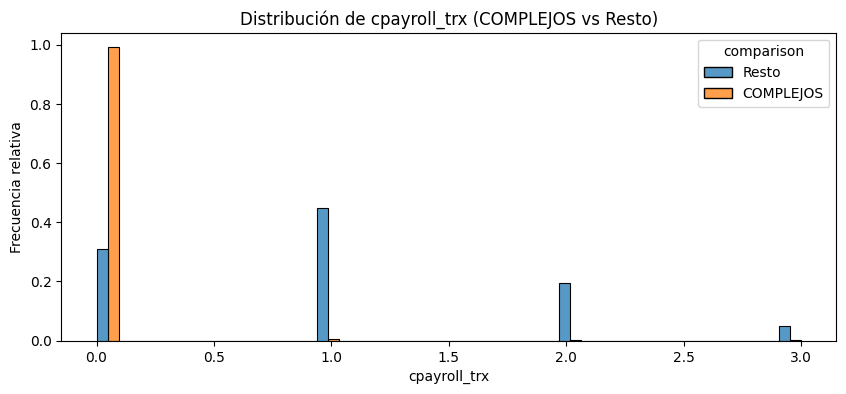

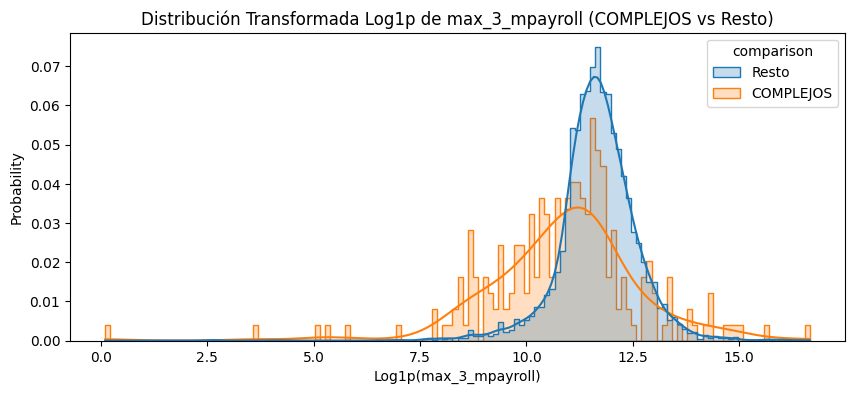

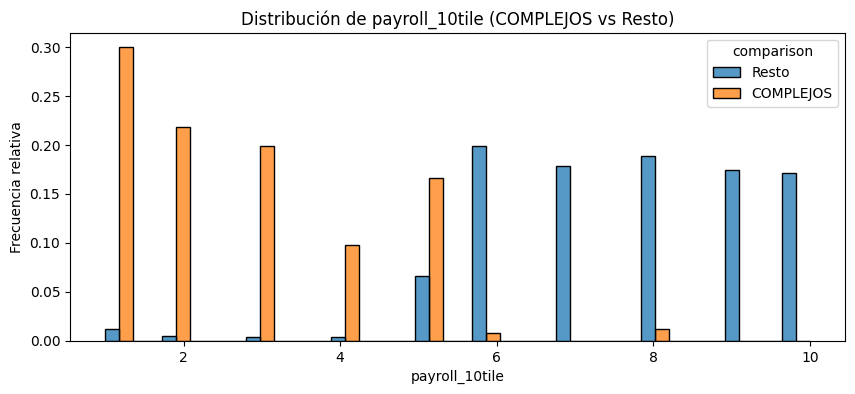

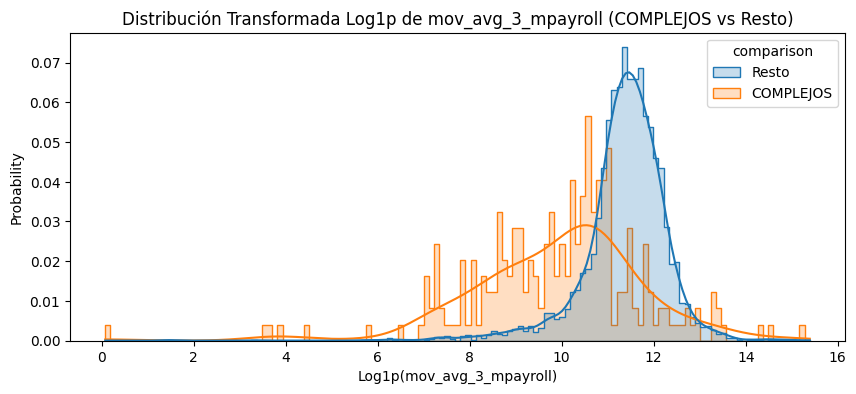

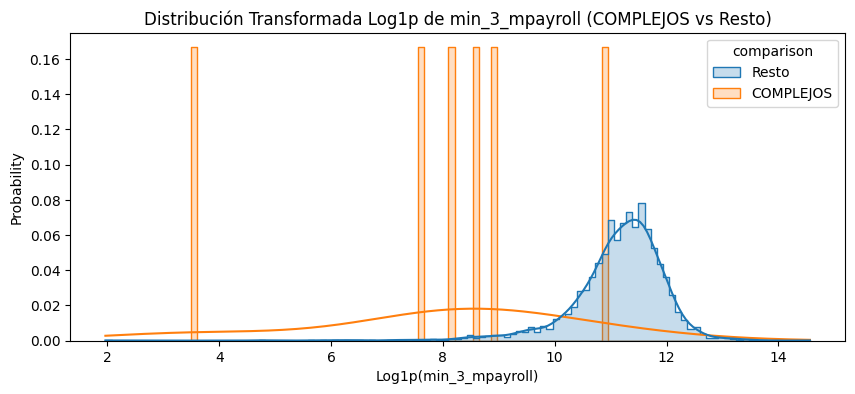

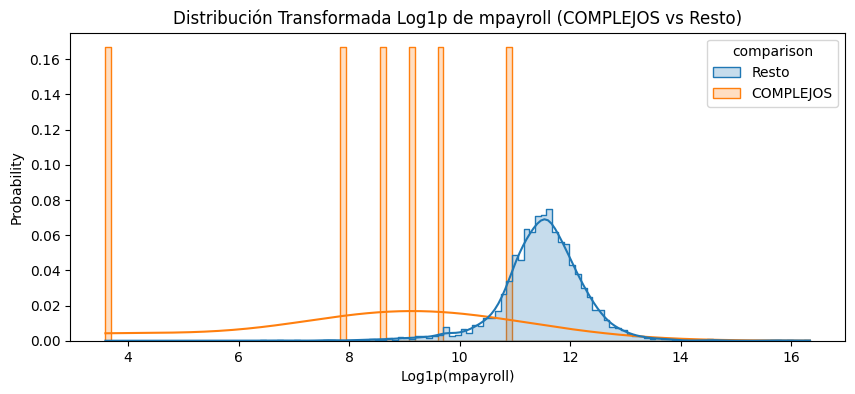

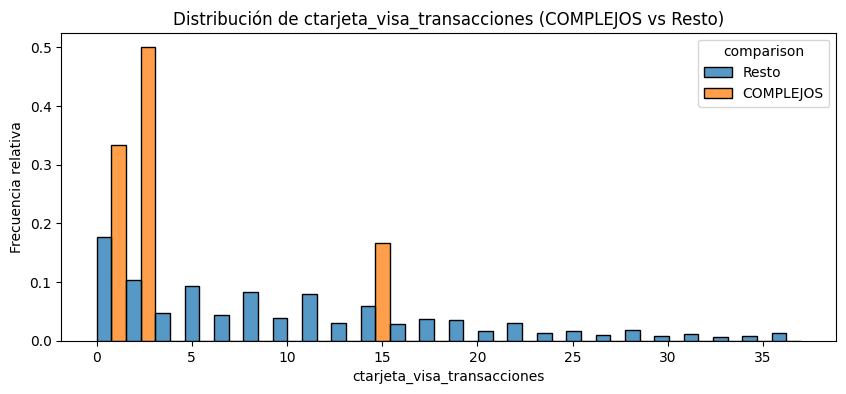

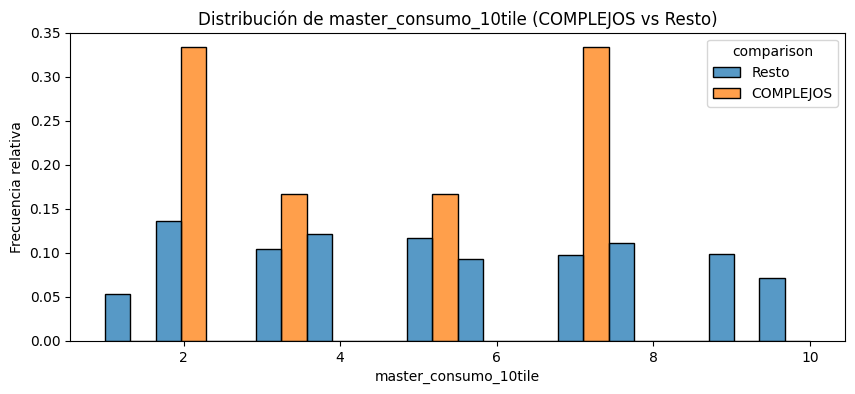

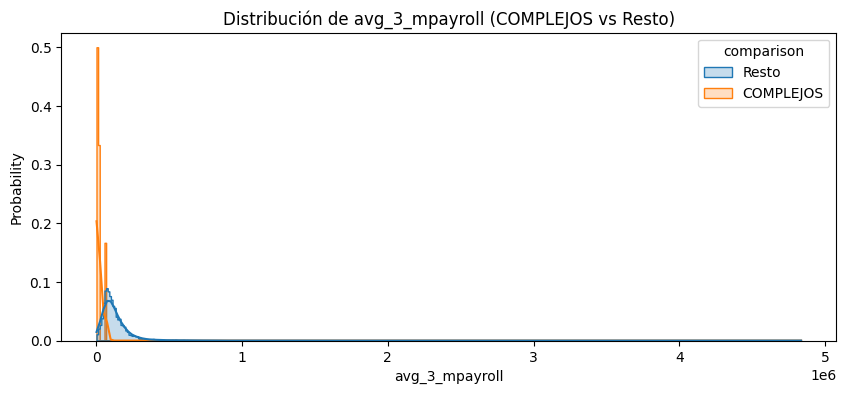

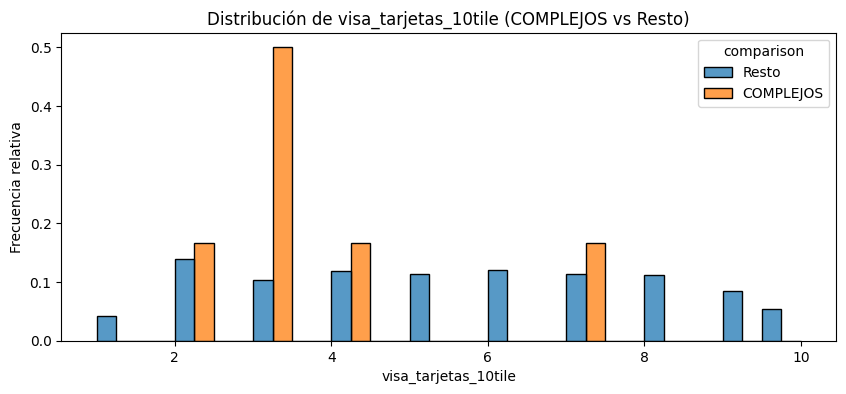


Comparando Cluster BAJAS contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  0 |   2.55422 |   97.7358 |      2.26415 |                    11.93 |


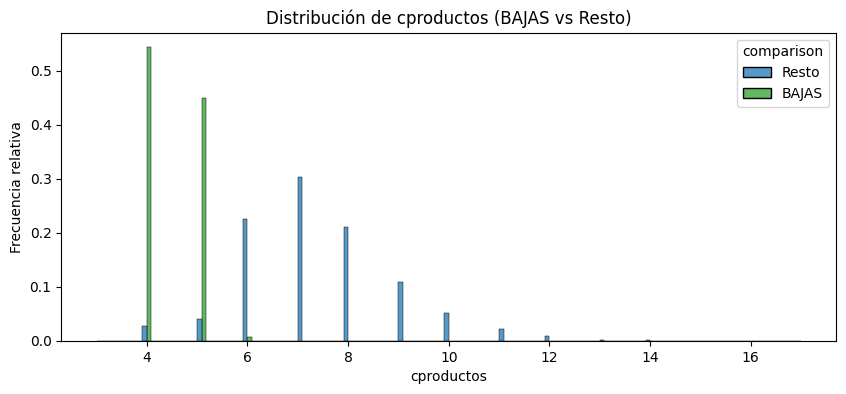

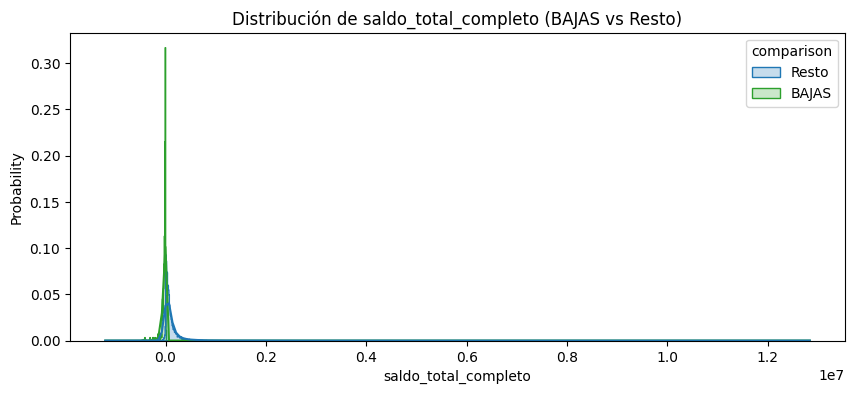

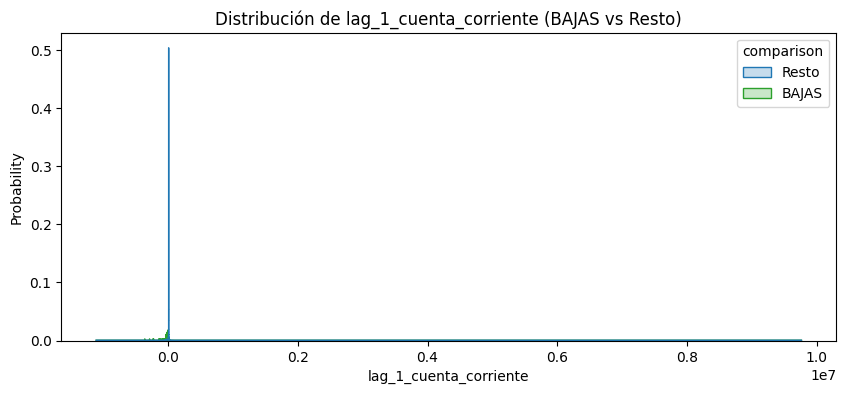

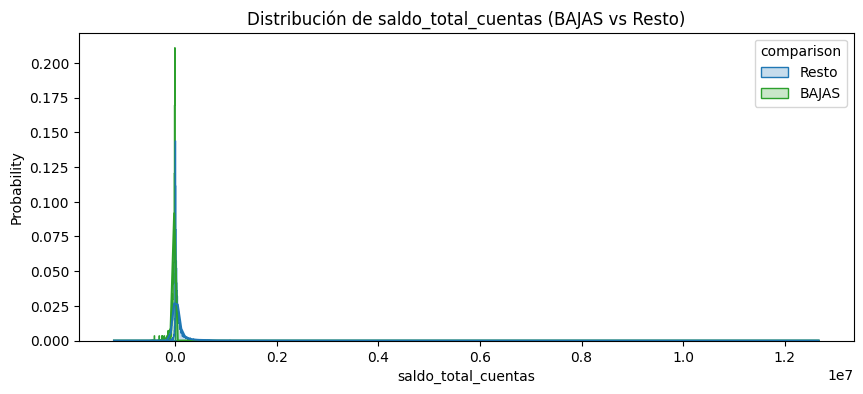

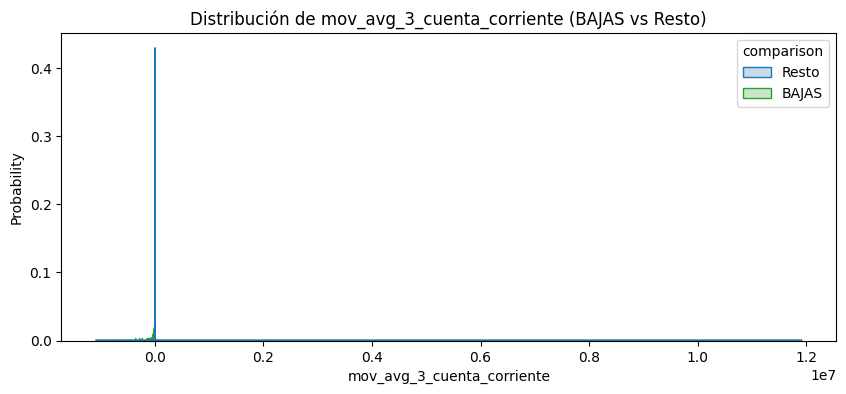

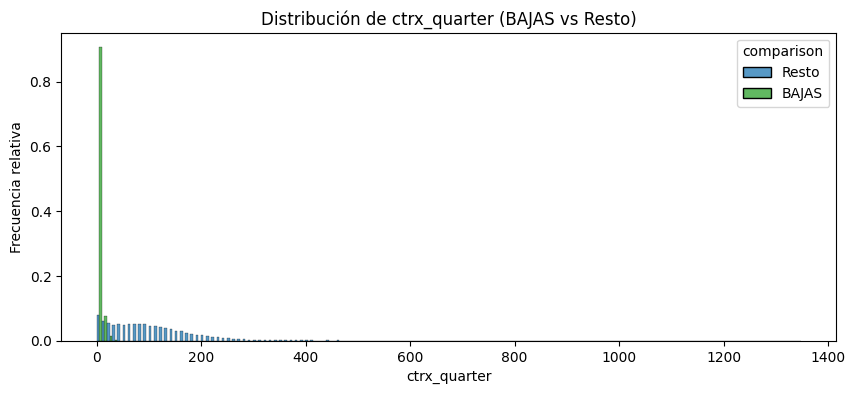

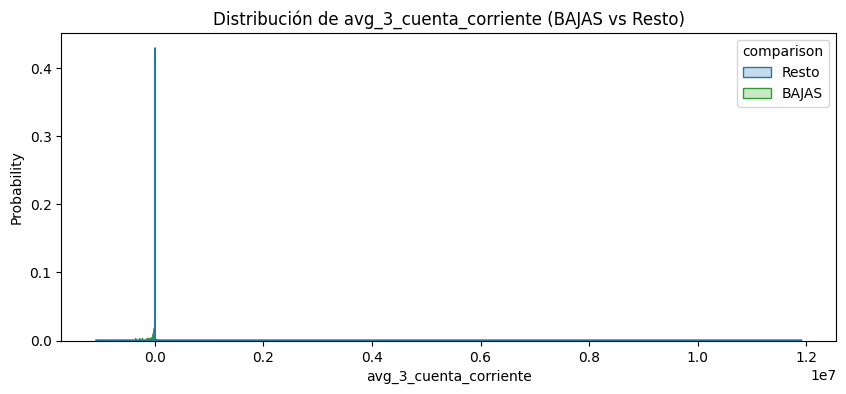

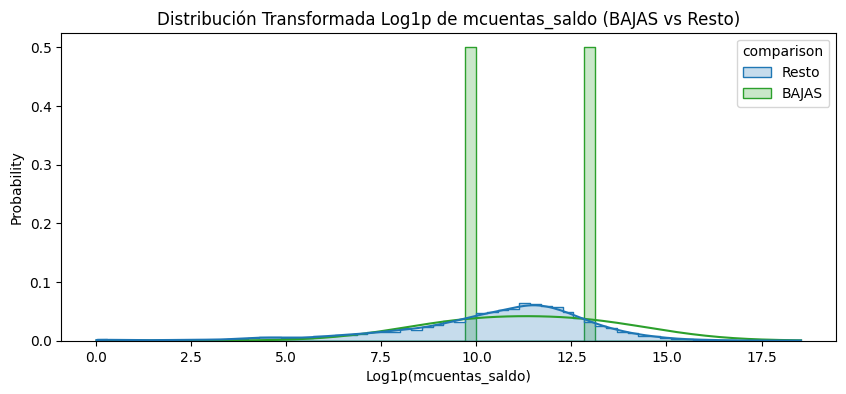

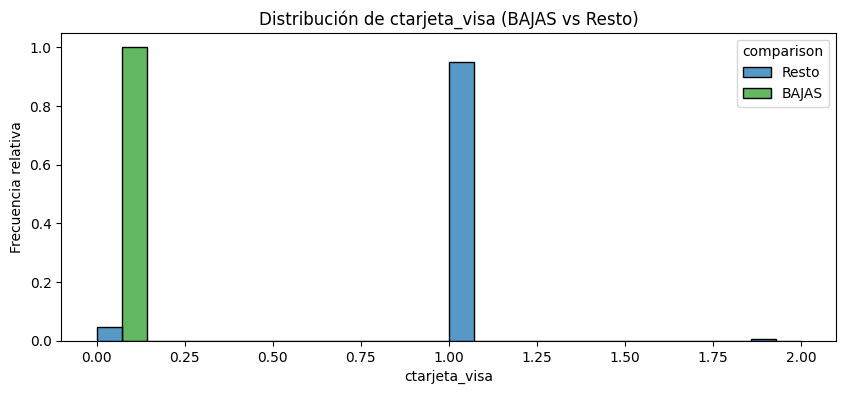

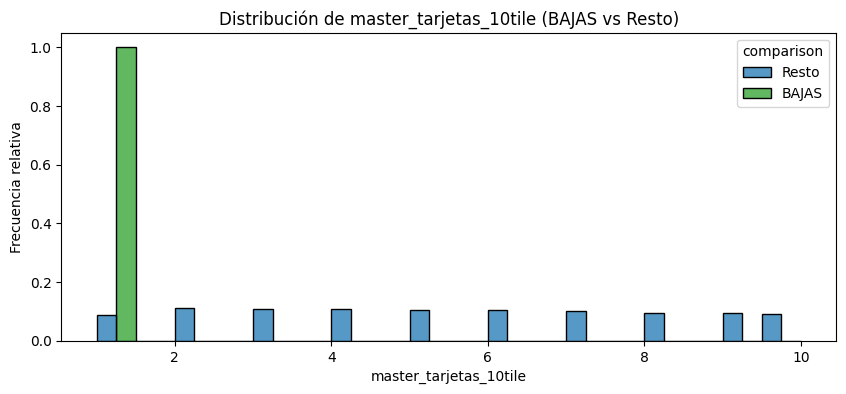


Comparando Cluster CONTINUA contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  4 |    35.412 |  0.925422 |      99.0746 |                   1.5661 |


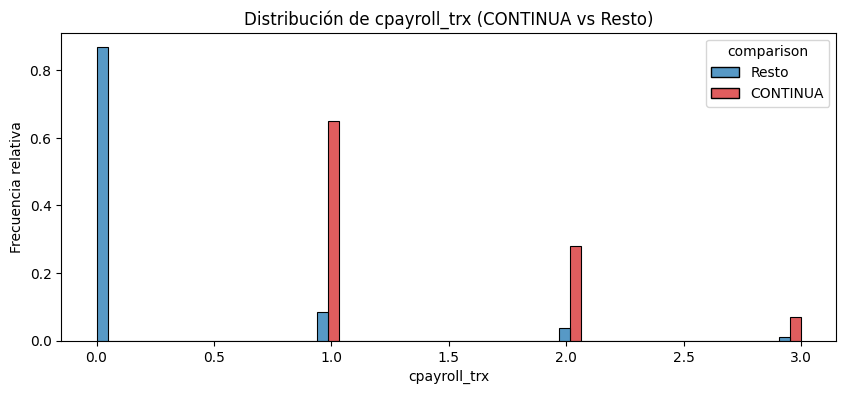

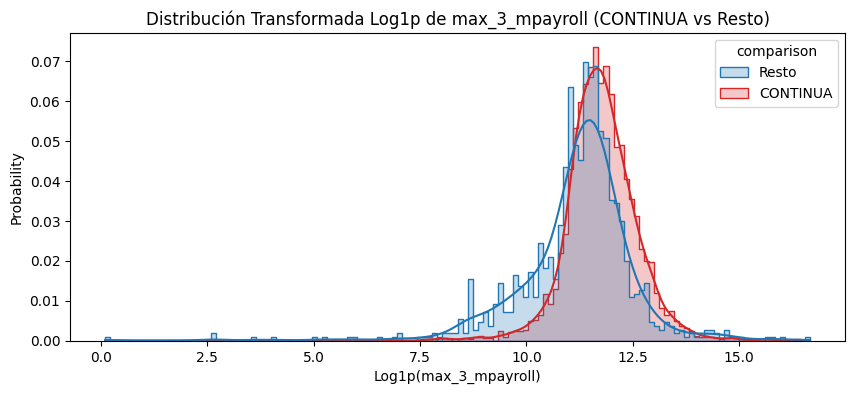

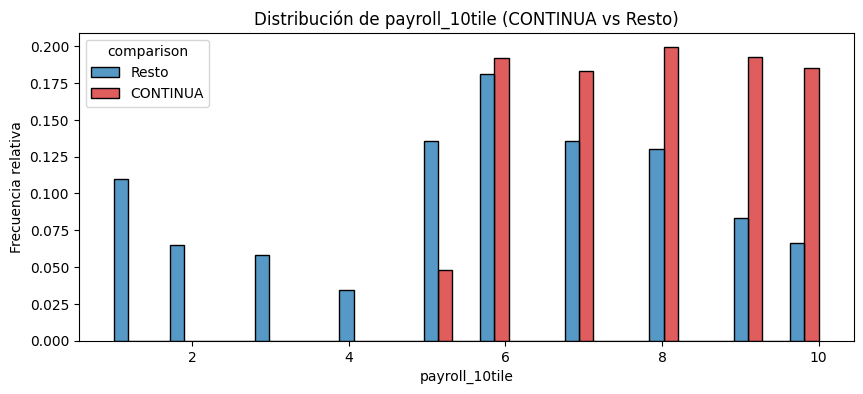

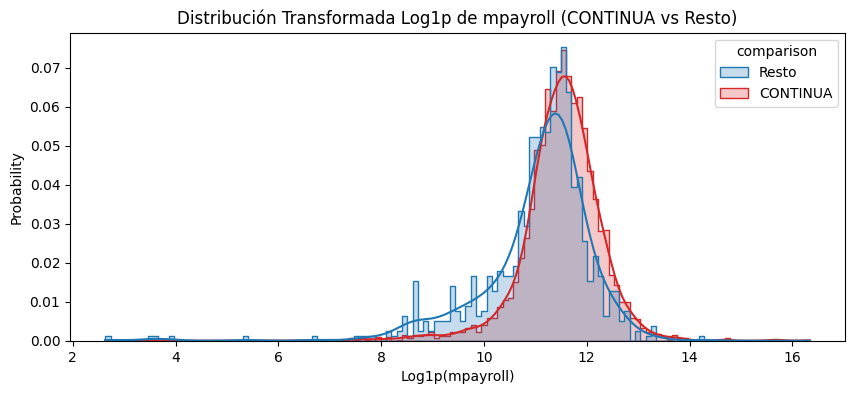

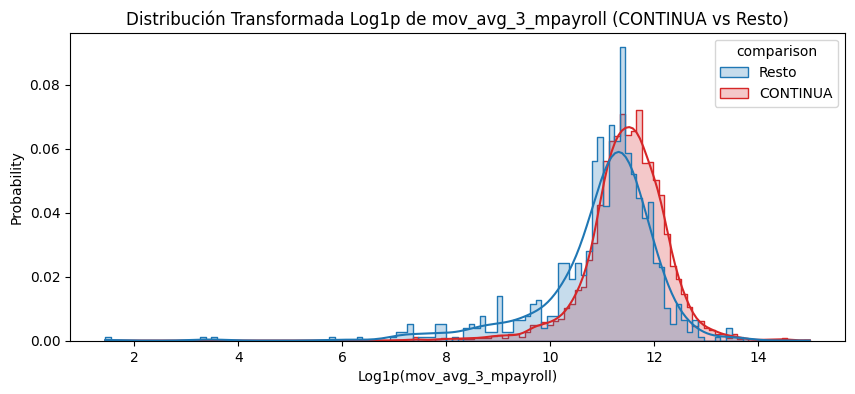

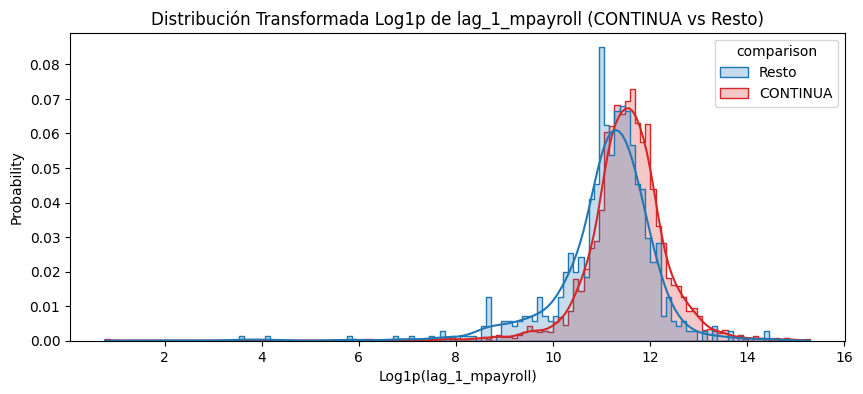

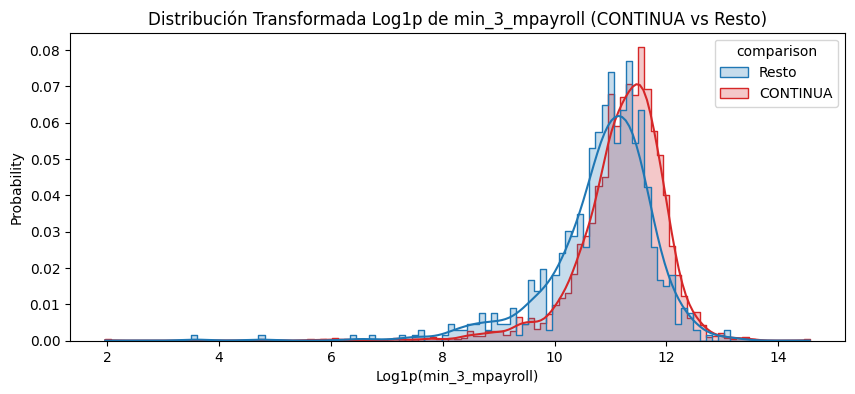

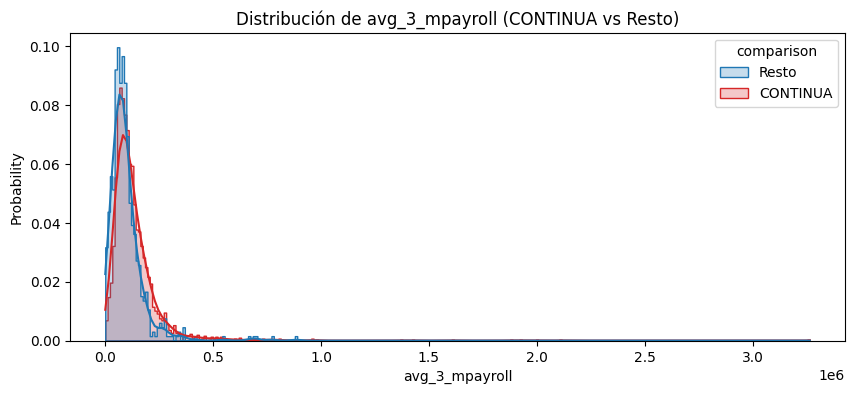

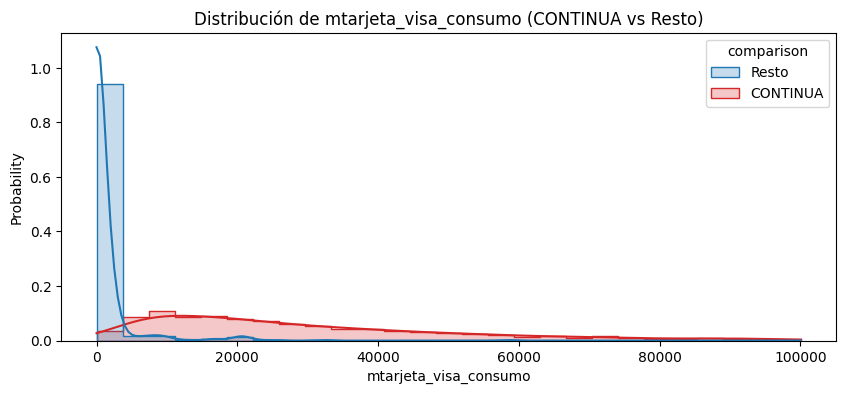

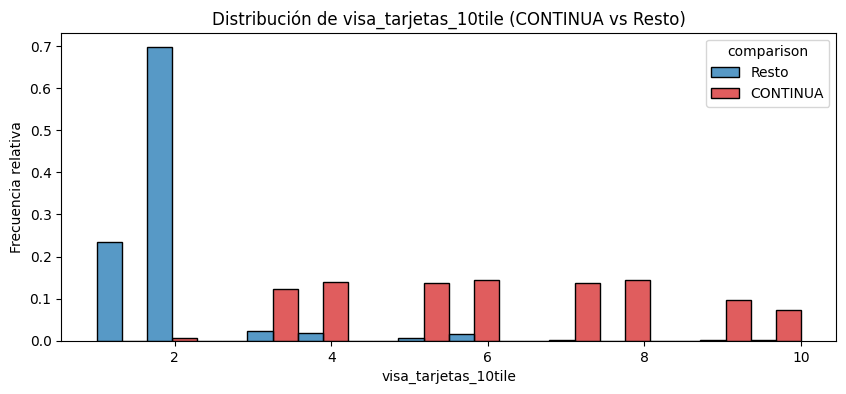


Comparando Cluster BAJAS dudosas contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  1 |   3.24819 |   40.9496 |      59.0504 |                  6.35652 |


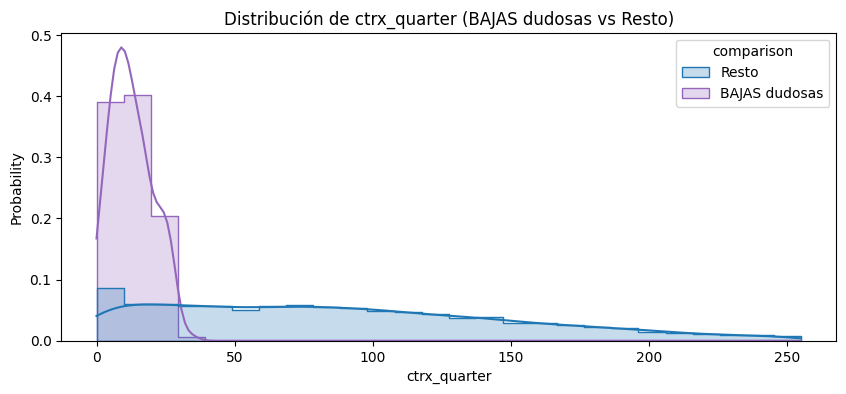

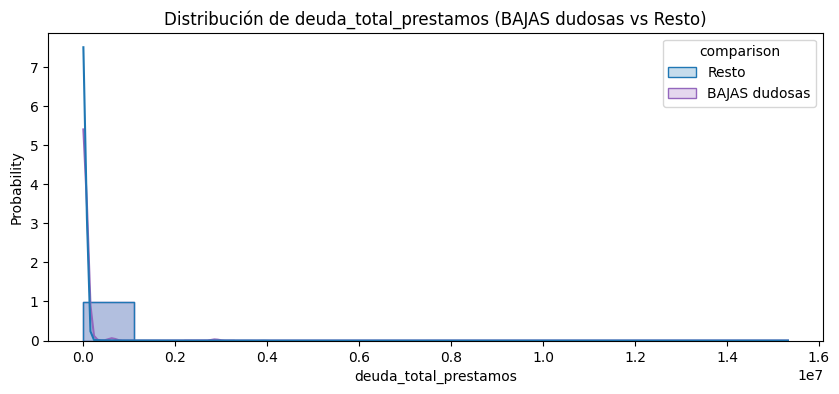

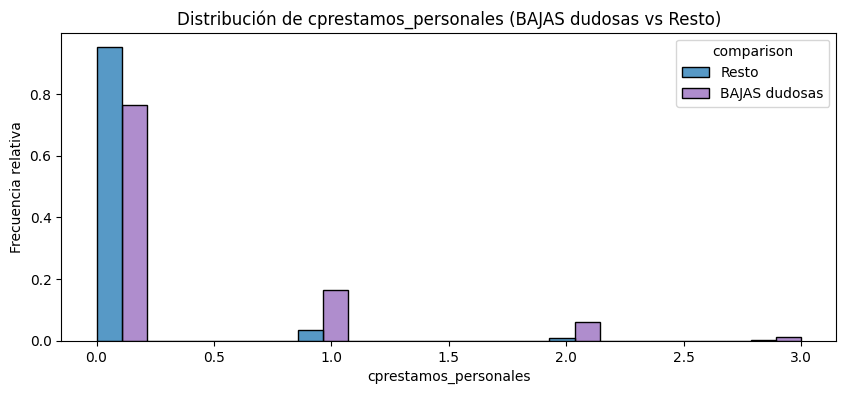

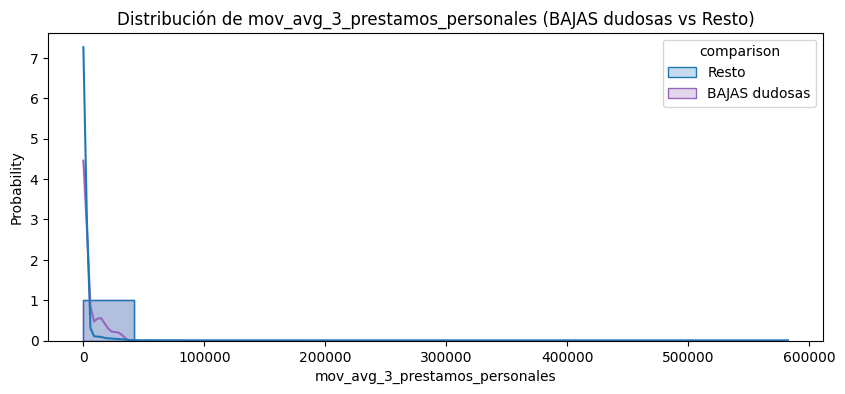

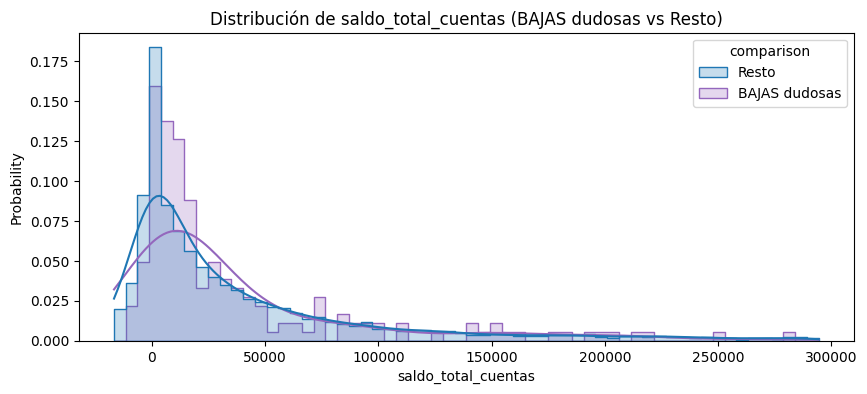

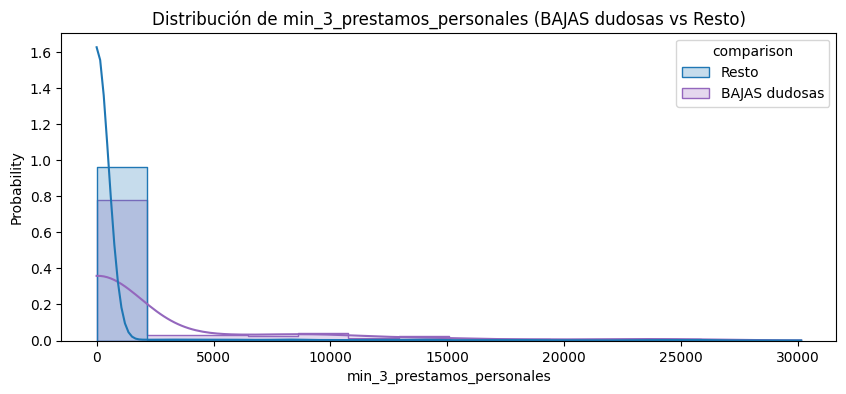

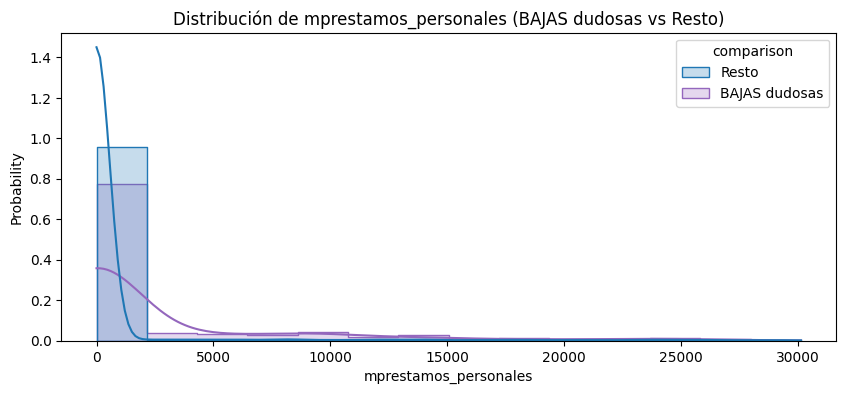

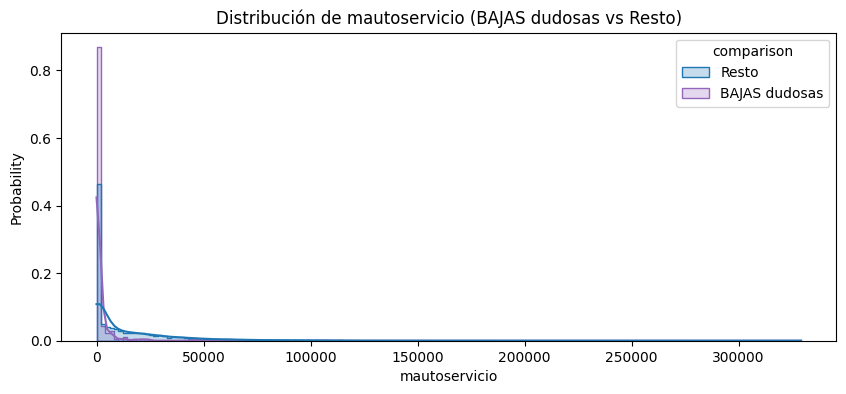

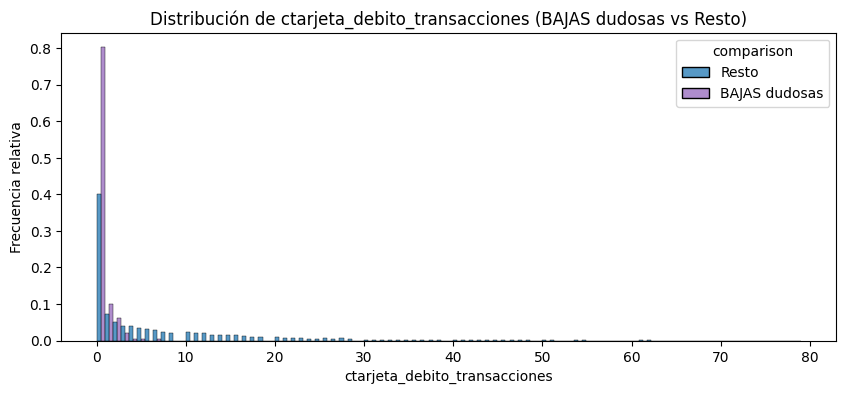

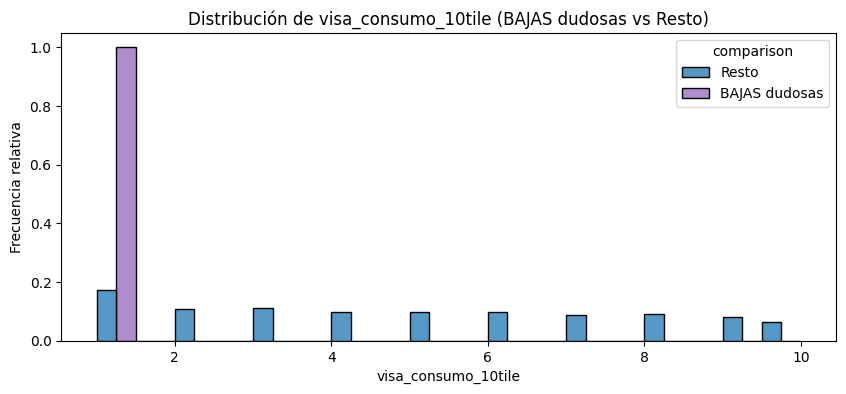


Comparando Cluster BAJAS probables contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  2 |   11.8843 |   65.8556 |      34.1444 |                  37.4021 |


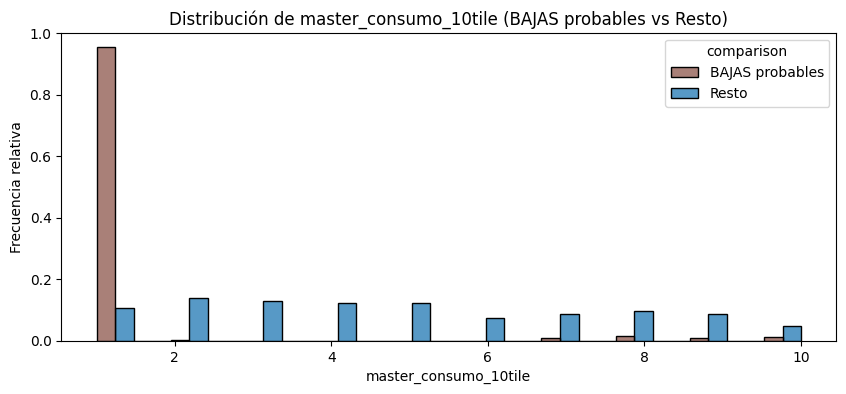

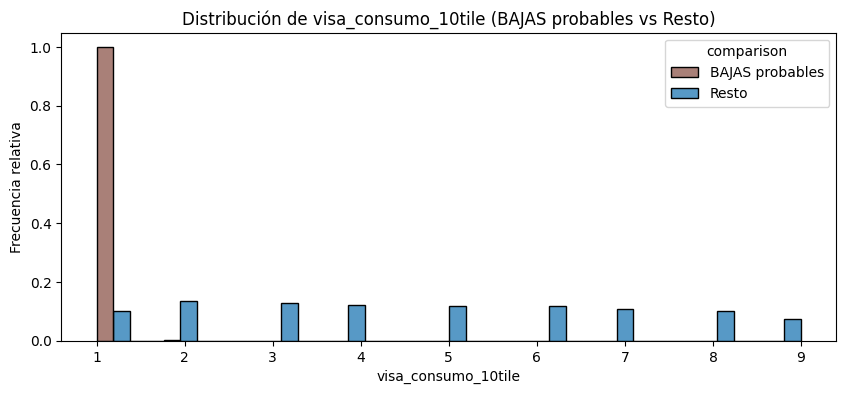

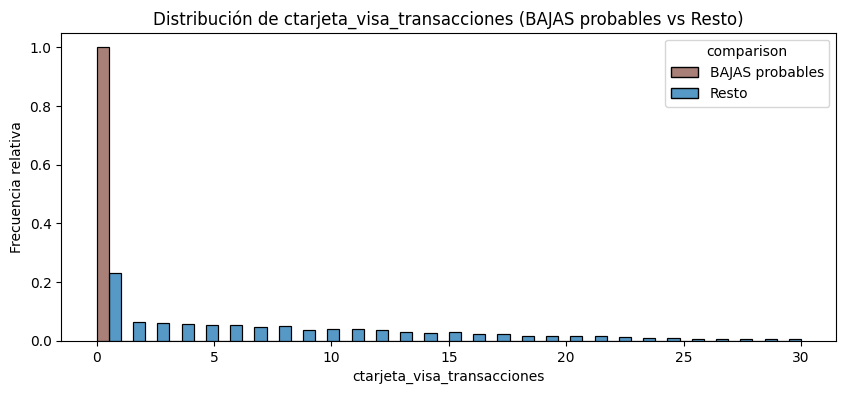

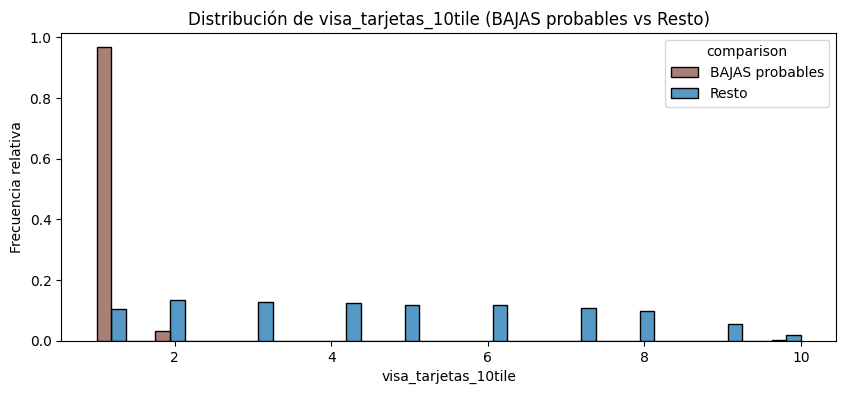

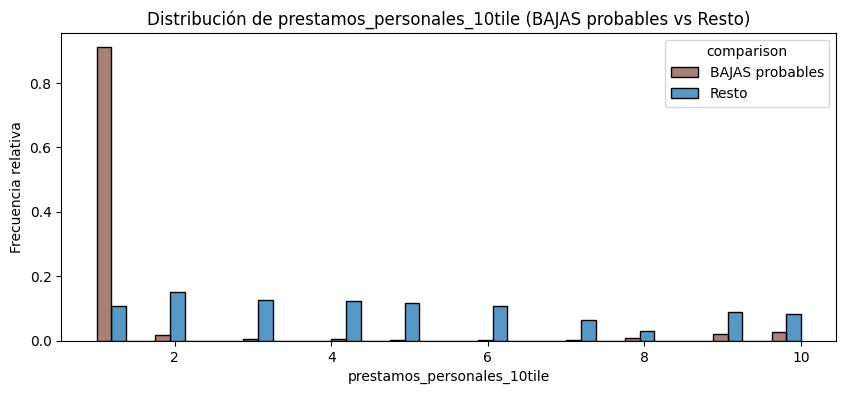

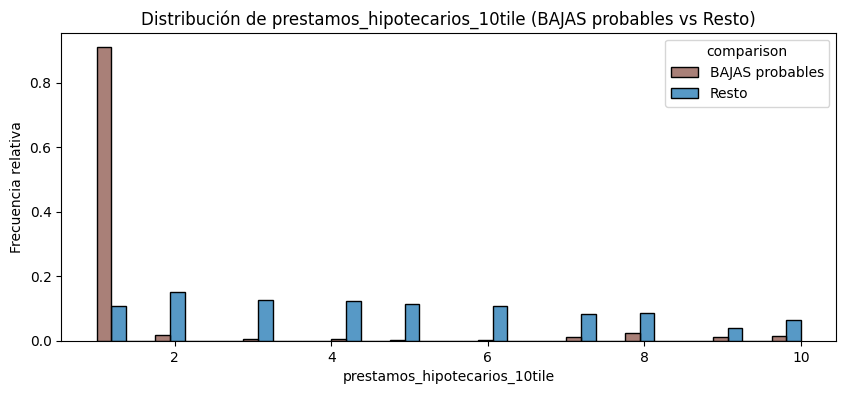

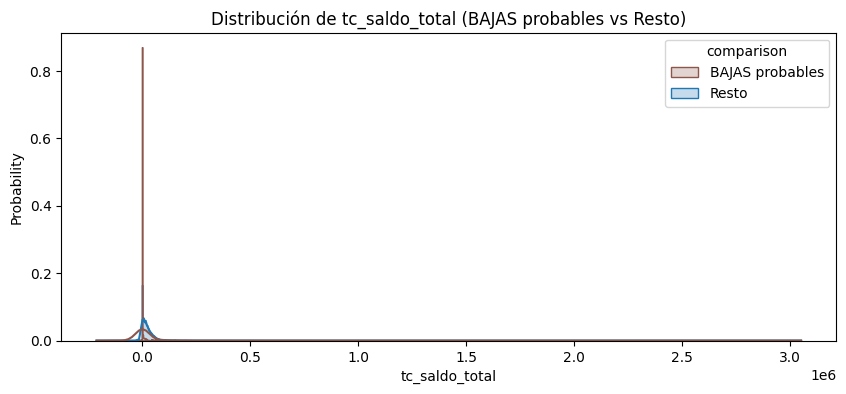

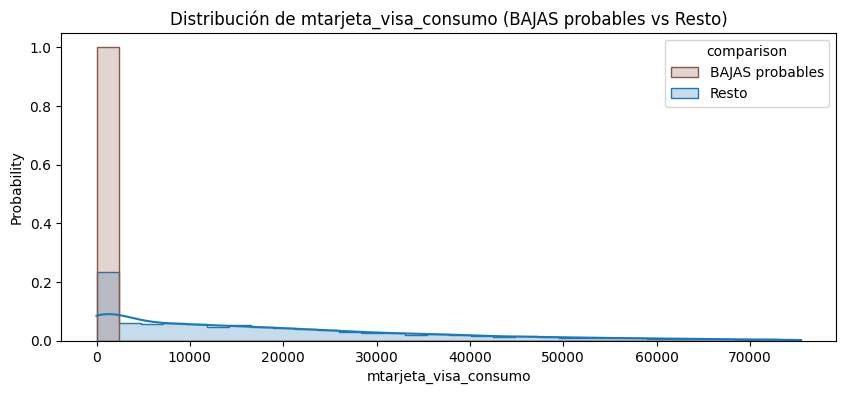

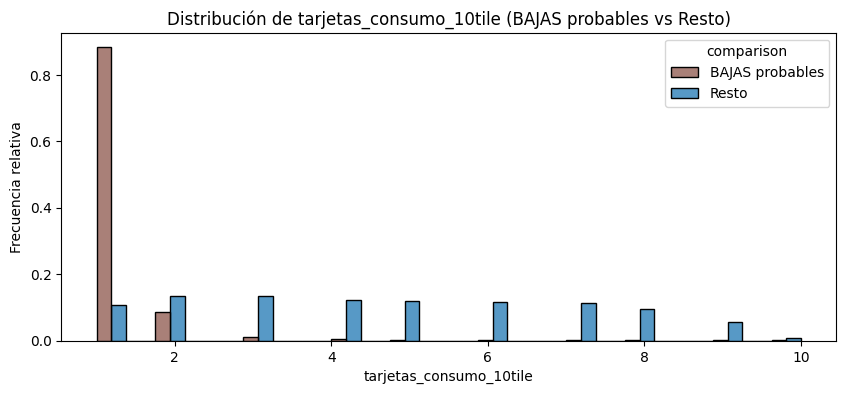

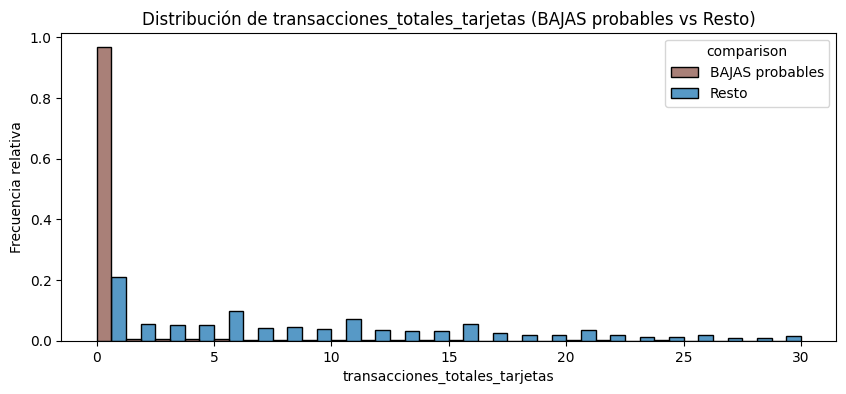


Comparando Cluster CONTINUA* contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  5 |   8.03855 |    5.7554 |      94.2446 |                  2.21096 |


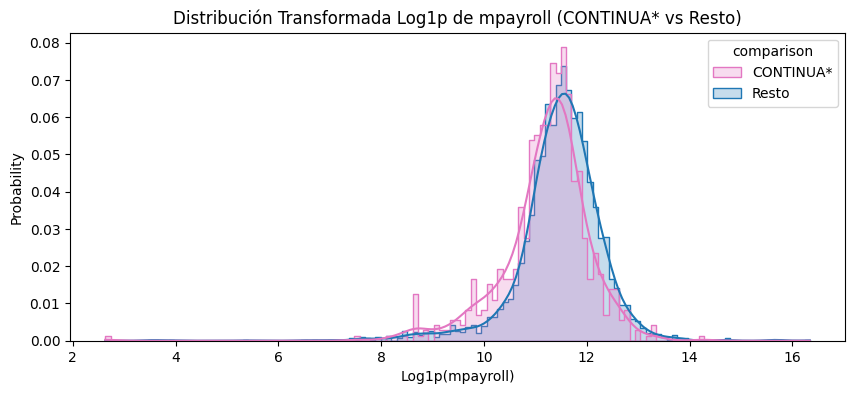

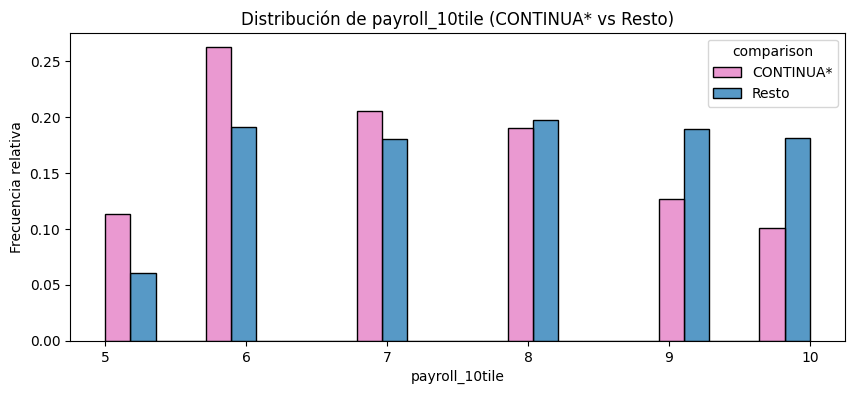

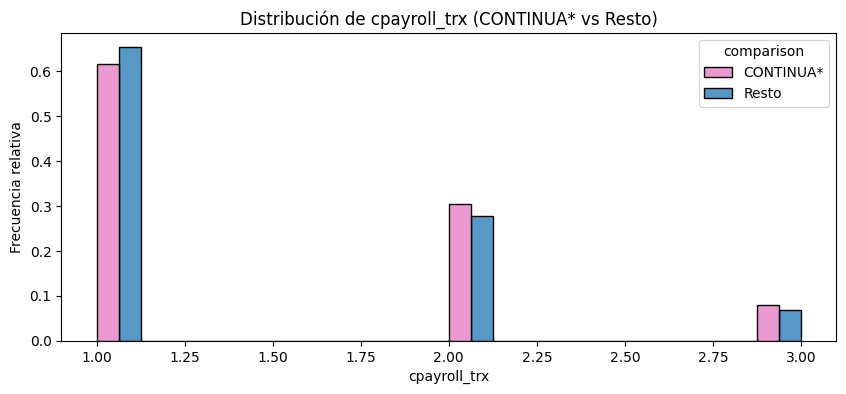

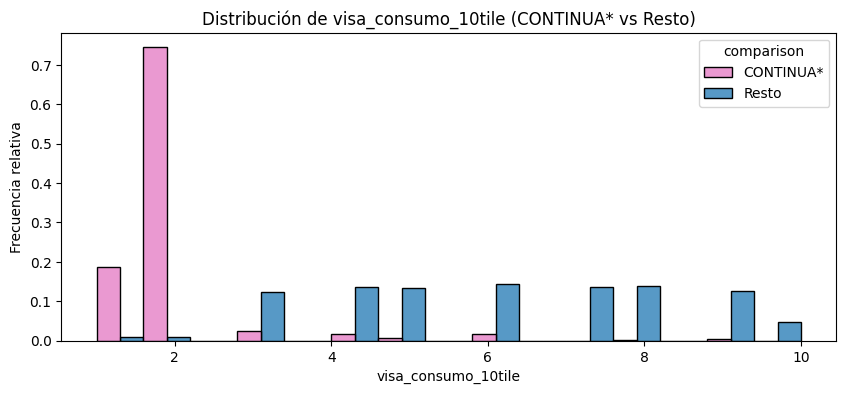

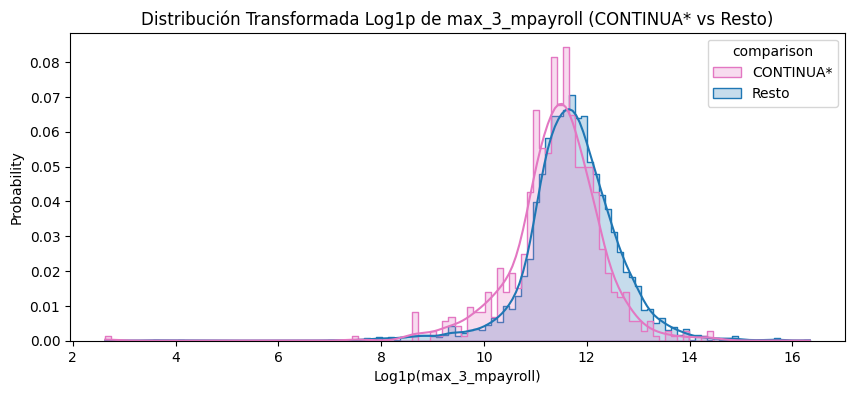

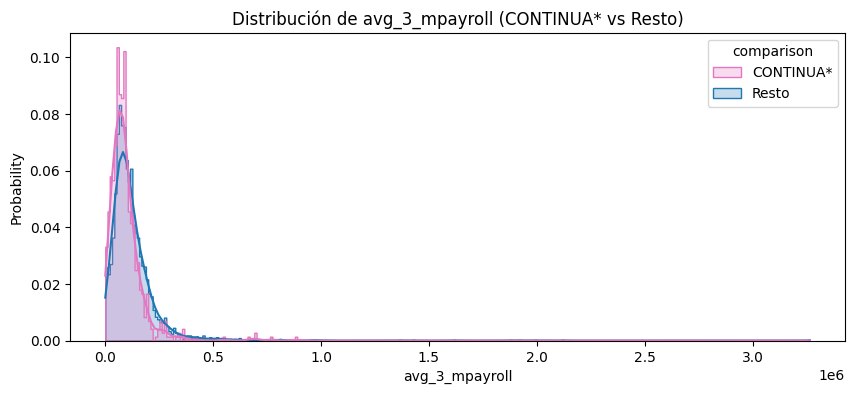

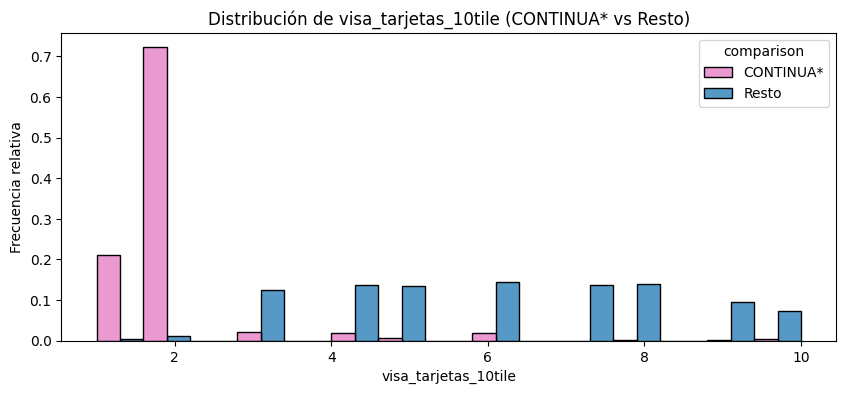

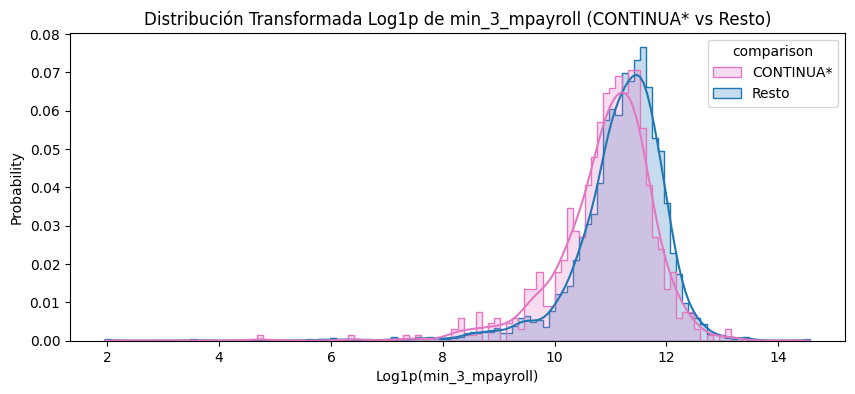

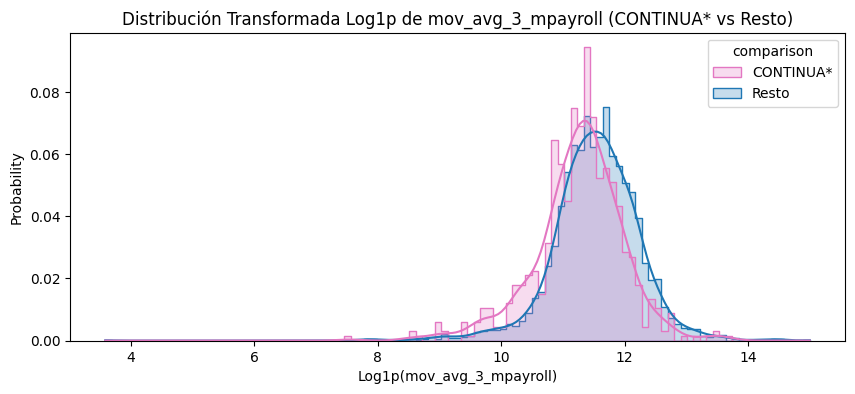

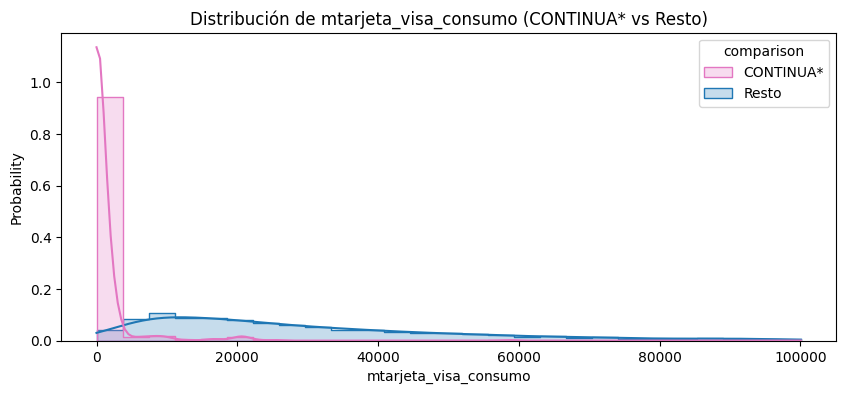


Comparando Cluster OUTLIERS contra el resto
|    |   Casos % |   Bajas % |   Continua % |   Bajas sobre el total % |
|---:|----------:|----------:|-------------:|-------------------------:|
|  6 | 0.0385542 |        25 |           75 |                0.0460617 |


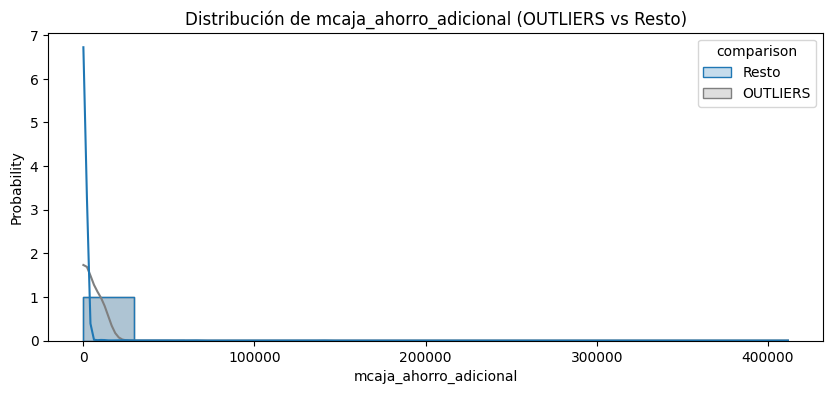

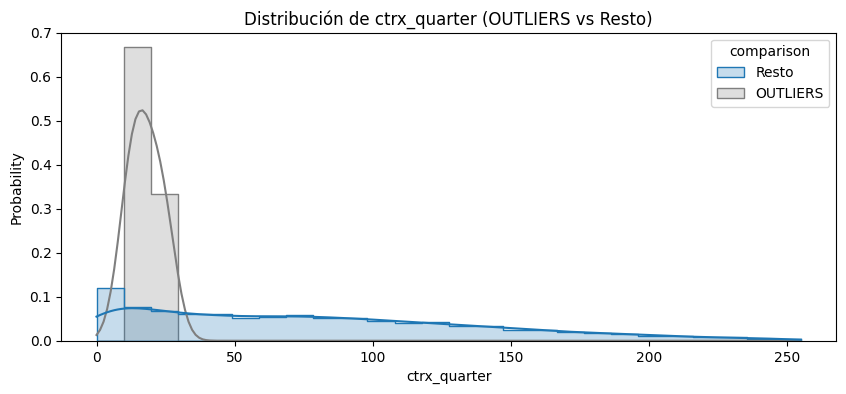

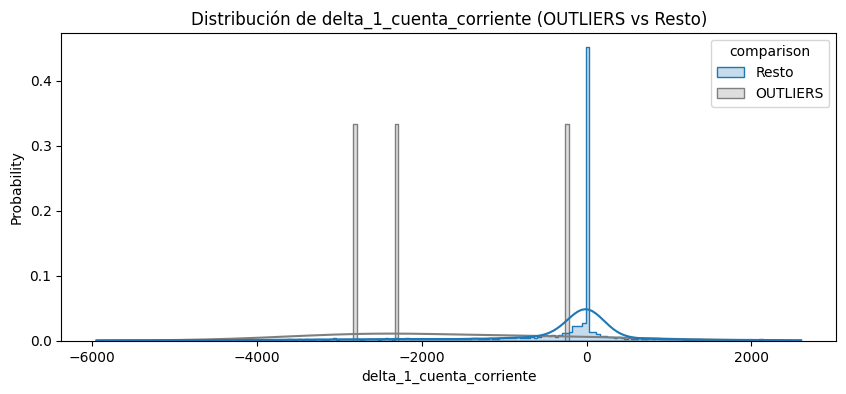

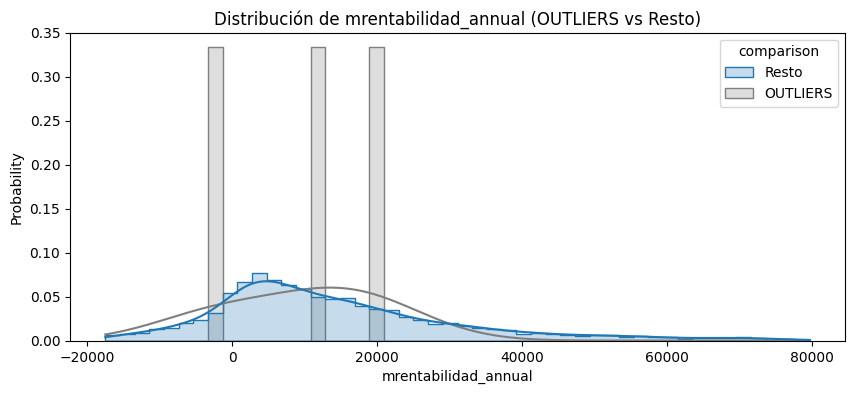

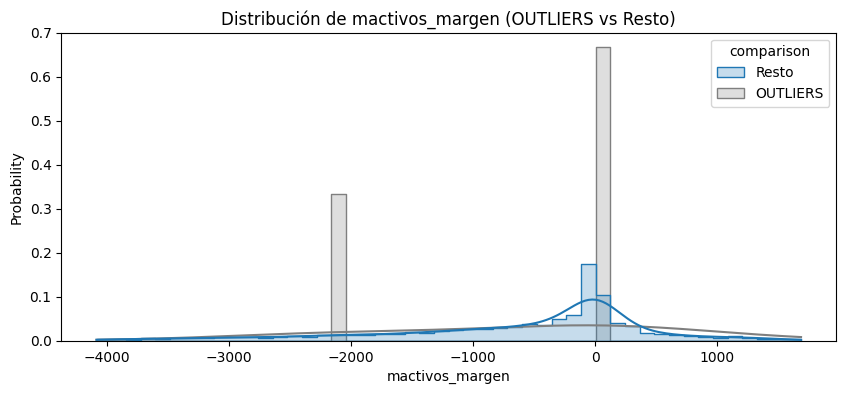

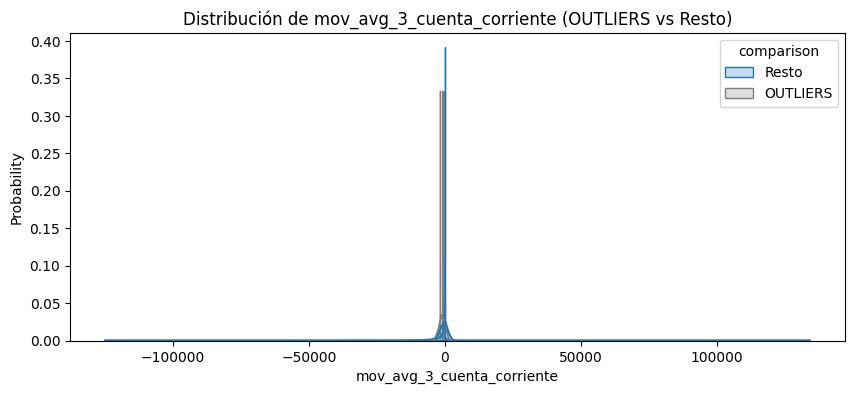

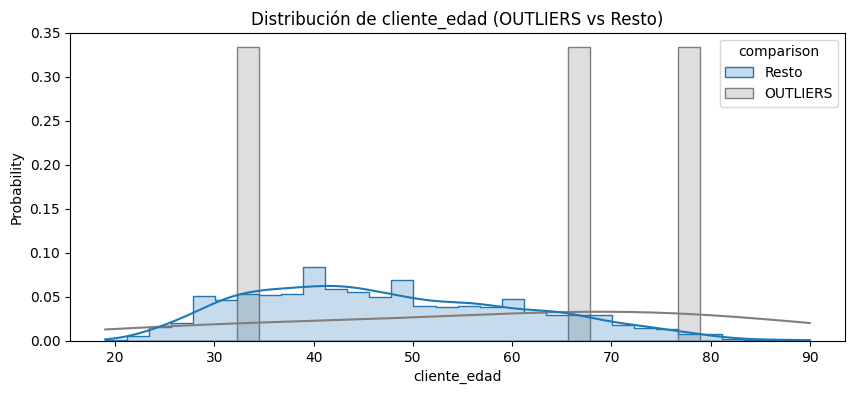

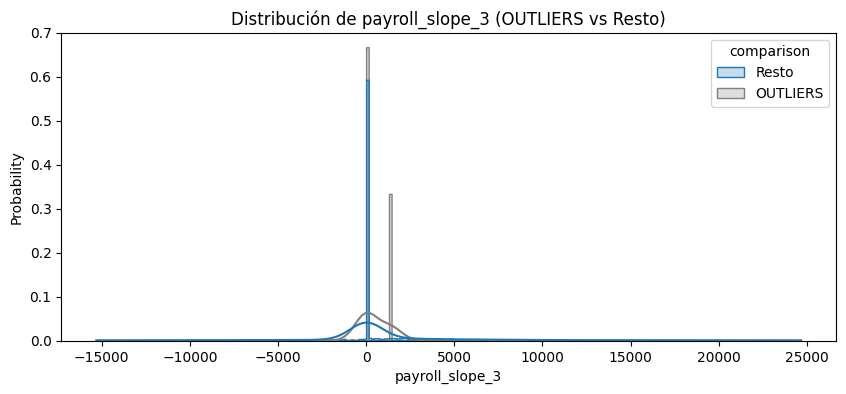

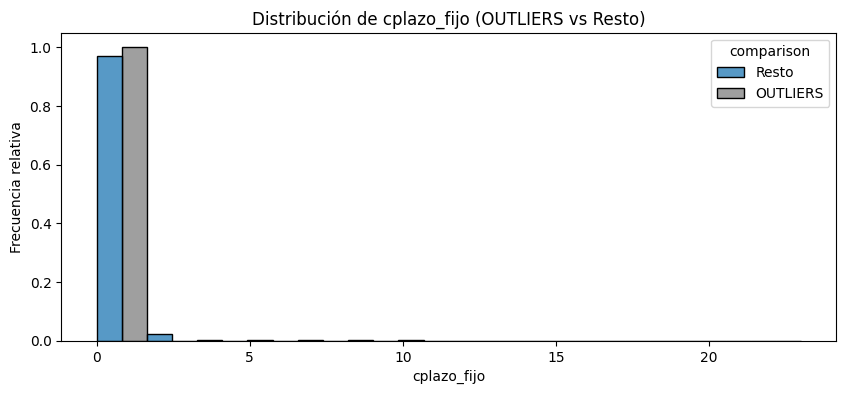

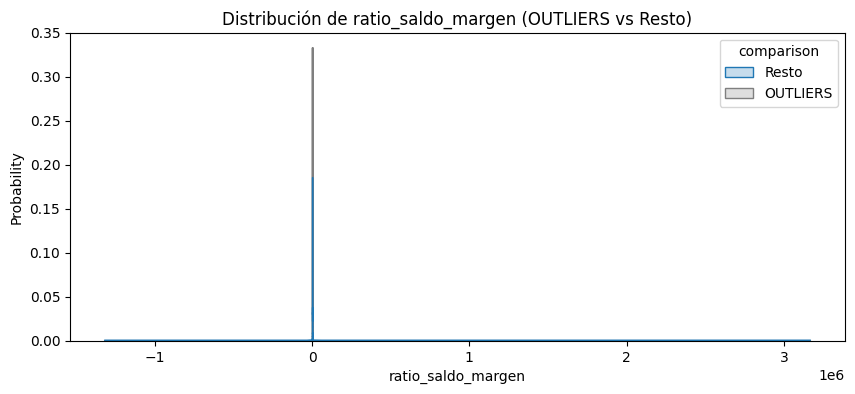

In [156]:
var_config = VariableTransformConfig()

to_log = var_config.to_log

plot_distributions_by_cluster(df_segmented, 
                              important_features_by_cluster_red, 
                              target='cluster_red',
                              top_n=10, sample_frac=1, 
                              transform='log1p', 
                              to_log=to_log,
                              cluster_stats=cluster_stats,
                              variable_config=var_config)

## Iniciativas para abordar la problemática

**Campaña de estímulos** a clientes premium, a los fines de evitar su baja en nuestra institución.

Según avances del equipo de marketing, el estimulo sería de 7 mil $ y la ganancia de acertar con el mismo de 240 mil $.

¿Cómo lo hacemos?

**Modelo predictivo**

Queda claro, luego de este análisis, que hay segmentos bien distinguible entre los clientes con paquetes premium.

El segmento BAJAS es probablemente fácil de distinguir, sin necesidad de modelos predictivos complejos, pero solo representa un 12 % de las BAJAS y 2.5 % de los casos estudiados.

Por su parte, el segmento CONTINUA también parece sencillo de identificar, pero solo cubre el 35 % de la muestra evaluada.

En el 62.5 % de los casos restantes, los segmentos dejan de ser facilmente separables.

--

Ampliando a BAJAS probables, alcanzaríamos un 49 % de las BAJAS, pero reduciendo drásticamente la precisión de los estímulos.